## Maternal health risk prediction Model building
The experiment is conducted on a Windows 10 system with 8GB of RAM, using Python 3.11.4 

## 1.0 Import necessary libraries

In [1]:
# loading and reading data
import numpy as np
import pandas as pd

# libraries for visualizations
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Library for splitting data
from sklearn.model_selection import train_test_split


# library for scaling
from sklearn.preprocessing import StandardScaler

# library to encode categorical data
from sklearn.preprocessing import LabelEncoder

#Library for traditional models
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as LGB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


#library for deep neural network models
from keras.models import Sequential
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping

# library for hyper-parameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from scipy.stats import randint, uniform

# library for data augmentation
from imblearn.over_sampling import SMOTE

# library for result evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc , roc_curve, roc_auc_score
from sklearn.metrics import classification_report,ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve

from sklearn.preprocessing import FunctionTransformer

from scipy.stats import boxcox

# Others
from sklearn.preprocessing import label_binarize
import time
import warnings

## 2.0 Read in the Data

In [2]:
# load the data set(maternal_health data)

df = pd.read_csv('Maternal Health Risk Data Set.csv')


In [3]:
# Check the first 5 columns of the data set
df.head(5)

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


### 2.1 Data Features explanation
|Feature	|Description	                                                                    |Unit      |
|-----------|-----------------------------------------------------------------------------------|----------|
|Age	    |Ages in years when a woman is pregnant	                                            |          |
|SystolicBP	|Upper value of Blood Pressure                                                      |mmHg      |
|DiastolicBP|Lower value of Blood Pressure	                                                    |mmHg      |
|BS	        |Blood glucose levels is in terms of a molar concentration	                        |mmol/L    |
|BodyTerm	|Bodytemperature	                                                                |Fahrenheit|
|HeartRate	|A normal resting heart rate	                                                    |bpm       |
|RiskLevel	|Predicted Risk Intensity Level during pregnancy considering the previous attribute |          |	


## 3.0 Data Overview

- Data Stucture
- Data Quality check
- Data Descriptive analysis

### 3.1 Data Structure

| Task           | Objective                                             |
|----------------|-------------------------------------------------------|
| Data Dimension | To know the number of columns and rows of the dataset |
| Data Types     | To verify that the data types align with the features |
| Data Columns   | To list and understand the columns                    |


In [4]:
# checking the dimensionality of the data set
print(f" Data set Dimensions: {df.shape}")

print('---------------------------------------')
# Checking the data types
print(f" Data types:\n{df.dtypes}")

print('----------------------------------------')
# check the data columns
print(f" Data columns: {df.columns}")


 Data set Dimensions: (1014, 7)
---------------------------------------
 Data types:
Age              int64
SystolicBP       int64
DiastolicBP      int64
BS             float64
BodyTemp       float64
HeartRate        int64
RiskLevel       object
dtype: object
----------------------------------------
 Data columns: Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel'],
      dtype='object')


### 3.2 Data Quality Check


In [5]:
# check for missing value
print(f"missing value: {df.isnull().sum()}")

missing value: Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64


***Observation***: No missing value exist in our data

### 3.3 Data descriptive analysis


In [6]:
# check the summary statistics of numerical features
print('The summary Statistics of numerical features:')
df.describe().T

The summary Statistics of numerical features:


,count,mean,std,min,25%,50%,75%,max
Age,1014.0,29.871795,13.474386,10.0,19.0,26.0,39.0,70.0
SystolicBP,1014.0,113.198225,18.403913,70.0,100.0,120.0,120.0,160.0
DiastolicBP,1014.0,76.460552,13.885796,49.0,65.0,80.0,90.0,100.0
BS,1014.0,8.725986,3.293532,6.0,6.9,7.5,8.0,19.0
BodyTemp,1014.0,98.665089,1.371384,98.0,98.0,98.0,98.0,103.0
HeartRate,1014.0,74.301775,8.088702,7.0,70.0,76.0,80.0,90.0


***Observations on the statistic check of the numerical data***
The minimum heart rate is 7 and the maximum is 70. It is biologically impossible to have a heart rate of 7. According to the guiness world record, the lowest heartrate ever recorded is 27bmp. This will be considered as data inputation error. We will investigate and find the number of rows with this anomaly and treat accordingly

In [7]:
# check the number of entries with the heart rate anomaly
hrt_anomaly = df[(df['HeartRate'] >= 7) & (df['HeartRate'] <= 26)].shape[0]

print(f"Number of entries with heartrate between 7 and 26: {hrt_anomaly}")

Number of entries with heartrate between 7 and 26: 2


In [8]:
# Check for the mode of the HeartRate column
hrt_mode = df['HeartRate'].mode()[0]

print(f"The mode of the Heart Rate : {hrt_mode}")

The mode of the Heart Rate : 70


In [9]:
# Replace the Heart Rate anomaly with the mode

df['HeartRate'] = df['HeartRate'].replace(7, hrt_mode)



In [10]:
# check the summary statistics of the class distribution of the target variable
print(df.describe(include='object'))

# Value counts for categorical features
print("\nCategorical Data Insights:")
print(df['RiskLevel'].value_counts())



       RiskLevel
count       1014
unique         3
top     low risk
freq         406

Categorical Data Insights:
RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


### 3.3.1 Further analysis on the numerical features

In [11]:
# Skewness and Kurtosis
print("\nSkewness and Kurtosis:")
for col in df.select_dtypes(include=['number']).columns:
    skewness_value = round(df[col].skew(),2)
    kurtosis_value = round(df[col].kurt(),2)
    print(f"{col}: Skewness = {skewness_value}, Kurtosis = {kurtosis_value}")


Skewness and Kurtosis:
Age: Skewness = 0.78, Kurtosis = -0.39
SystolicBP: Skewness = -0.25, Kurtosis = -0.61
DiastolicBP: Skewness = -0.05, Kurtosis = -0.95
BS: Skewness = 1.87, Kurtosis = 2.3
BodyTemp: Skewness = 1.75, Kurtosis = 1.45
HeartRate: Skewness = 0.07, Kurtosis = -0.48


***Observation on Skewness***
 1) Age is moderately skewed.
 2) BS and BodyTemp: positvely skewed, suggesting the presence of higher values pulling the tail of the distribution to the right
 
***Observation on Kurtosis***
 1) BS, BodyTemp: High positve kurtosis which indicates some extreme values or presence of outliers
 2) Age, SystolicBP, DiastolicBP, HeartRate: Negative kurtosis which suggests a flatter distribution with minimum outliers

## 4.0 Encode categorical Features

- From the data type check of 3.1, its observed that the feature 'RiskLevel' is in object form. This form is not generally accepatable by all ML algorithms. We will use mapping to encode it into a numerical form for ease of intepretation by our models

In [12]:
# Mapping risk levels to numeric values
risk_map = {'low risk': 0, 'mid risk': 1, 'high risk': 2}
df['RiskLevel_encode'] = df['RiskLevel'].map(risk_map)

## 5.0 Exploratory Data Analysis(EDA)
- **EDA** is a vital step in the data analysis process and it involves summarizing a dataset's main characteristics using visuals.
it's importance includes:
1) understand the data structure
2) detect patterns and anomalies
3) formuate hypothesis for further analysis

### 5.1. Univariate analysis on the target variable distribution
- **Bar plot:** to visualize the count of each class
- **Pie chart:** to visualize the percentage distribution of each class

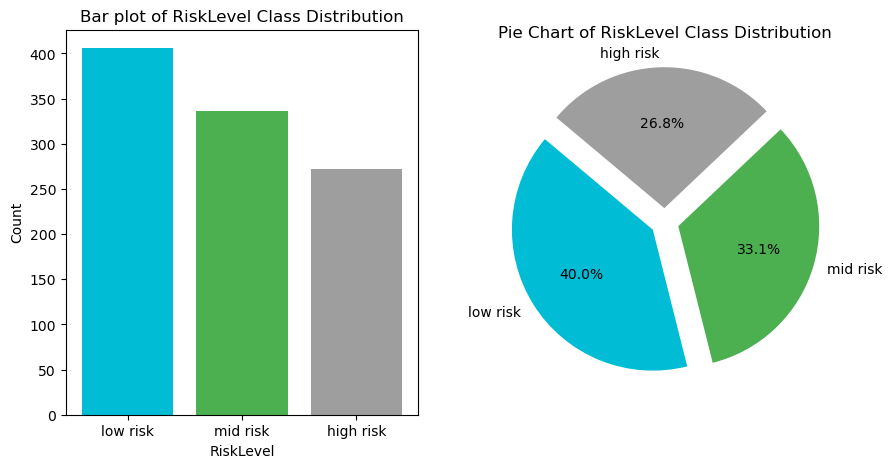

In [13]:
# Calculate the class distribution
class_dis = df['RiskLevel'].value_counts()

#create color tones
colors = ['#00bcd4', '#4caf50', '#9e9e9e']


# create subplots for bar plot and pie chart
fig, ax = plt.subplots(1,2, figsize=(10,5))

# Bar Chart
ax[0].bar(class_dis.index, class_dis.values, color=colors)#['gray', 'darkorange', 'cornflowerblue'])
ax[0].set_title('Bar plot of RiskLevel Class Distribution')
ax[0].set_xlabel('RiskLevel')
ax[0].set_ylabel('Count')


# Pie Chart
ax[1].pie(class_dis.values, labels=class_dis.index, autopct='%1.1f%%', startangle=140, explode=(0.1, 0.1, 0.1),
          colors=colors)#['gray', 'darkorange', 'cornflowerblue'])
ax[1].set_title('Pie Chart of RiskLevel Class Distribution')

# To display plot
plt.show();

***Observation on the RiskLevel Plot***

- The above plots suggest our target variable RiskLevel has low risk of 40%, mid risk of 33.1% and high risk of 26.8%.
This clearly indicates a somwwhat class inbalance among our target variable.

### 5.2. Correlation heat map of the features
- The heatmap is used to visualize the relationship between numerical features in the dataset
- **+1.0:** indicate perfect positive relation. positive values means as one feature increases, the other tends to increase too
- **-1.0:** indicate perfect negative relation. negative values means as one feature increases, the other decrease
- **0.0:** means no relation. suggesting the features has no linear relationship(no dependence)

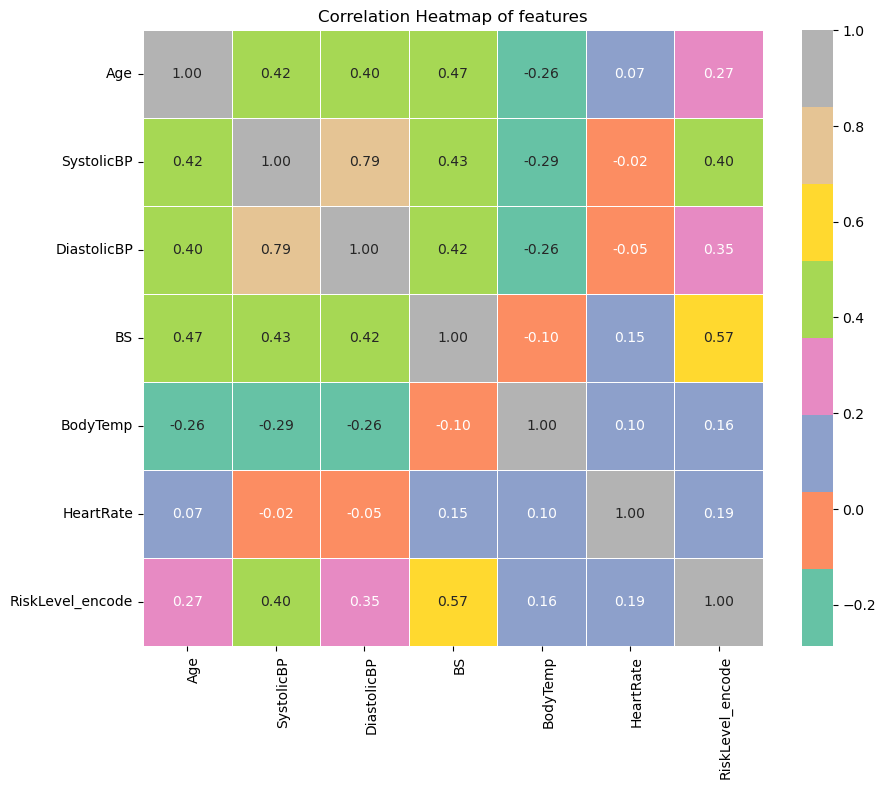

In [14]:
# Calculate the correlation matrix
corr_features = df.drop('RiskLevel', axis=1)
corr_matrix = corr_features.corr()

# set the colors for the heatmap
#custom_palette = sns.diverging_palette(30, 200, s=100, l=50, n=400, center="light")

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap= 'Set2', cbar=True, linewidths=0.5)
plt.xticks(rotation=90, ha='left')
plt.title('Correlation Heatmap of features')
plt.show();



***Corelation heatmap key observations***

- All features have a positive correlation with the target variable **RiskLevel**

- **features with strong positve correlations:**
    - **SystolicBP and DiastolicBP**  
     
- **features with moderate positive correlations:**
    - **Age with SystolicBP, DiastolicBP and BS (0.47)**

- **Low correlation:**
    - **BodyTemp and HeartRate:** shows very low or no correlation with other features, suggesting independence on other features.

### 5.3. 3D of some correlated features

***Plot 1***

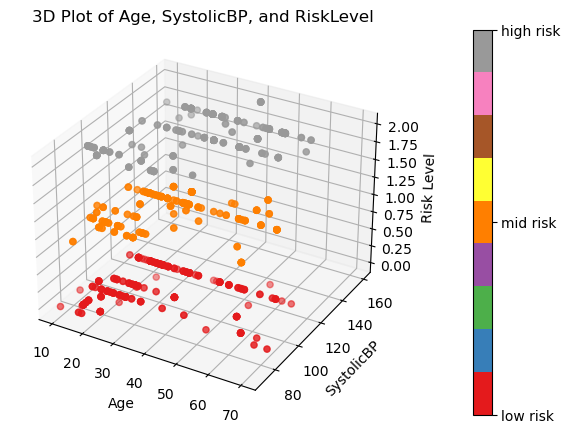

In [15]:
# Selecting features for the plot
feat1 = 'Age'
feat2 = 'SystolicBP'

color= ['#DDCC77', '#117733', '#332288']

# Creating the 3D plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

# Plotting the data
sc = ax.scatter(df[feat1], df[feat2], df['RiskLevel_encode'], c=df['RiskLevel_encode'], cmap='Set1', marker='o')

# Adding labels and title
ax.set_xlabel(feat1)
ax.set_ylabel(feat2)
ax.set_zlabel('Risk Level')
ax.set_title('3D Plot of Age, SystolicBP, and RiskLevel')

# Adding a color bar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['low risk', 'mid risk', 'high risk'])

plt.show()


***Plot 2***


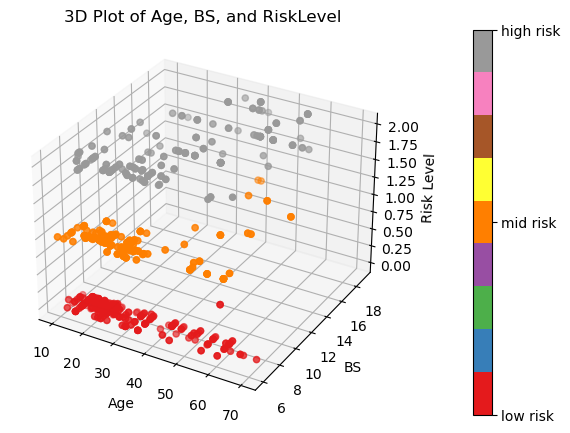

In [16]:
# additional 3D plot
feat3 = 'BS'
# Creating the 3D plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111, projection='3d')

# Plotting the data
sc = ax.scatter(df[feat1], df[feat3], df['RiskLevel_encode'], c=df['RiskLevel_encode'], cmap='Set1', marker='o')

# Adding labels and title
ax.set_xlabel(feat1)
ax.set_ylabel(feat3)
ax.set_zlabel('Risk Level')
ax.set_title('3D Plot of Age, BS, and RiskLevel')

# Adding a color bar
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['low risk', 'mid risk', 'high risk'])

plt.show()



***Observations from plots***

Plot 1 and plot 2 shows that risk levels are spread across different ages both younger and older. It further shows that age alone is not a determinate of risk in pregnancy. Instead, the risk level seems to be influenced by a combination of age and other factors such as blood sugar and Blood pressure.
- **High Risk**: Predominantly among higher systolicBP values and also higher Blood sugar thou present across the range of ages.
- **Mid and Low Risk**: shows the same pattern with high risk. Predominant among Lower systolicBP and Blood sugar



### 5.4. Visualizing skewness using Histogram

- **Skewness** measures how evenly spread the bell curve  on data points is on both sides of the median. if the spread is tilted more to the left than the right, it is said to be negatively skew and positively skewed if tilted more to the right than to the left. The data points is said to be zero symmetric if the bell shape have an even distribution on both sides

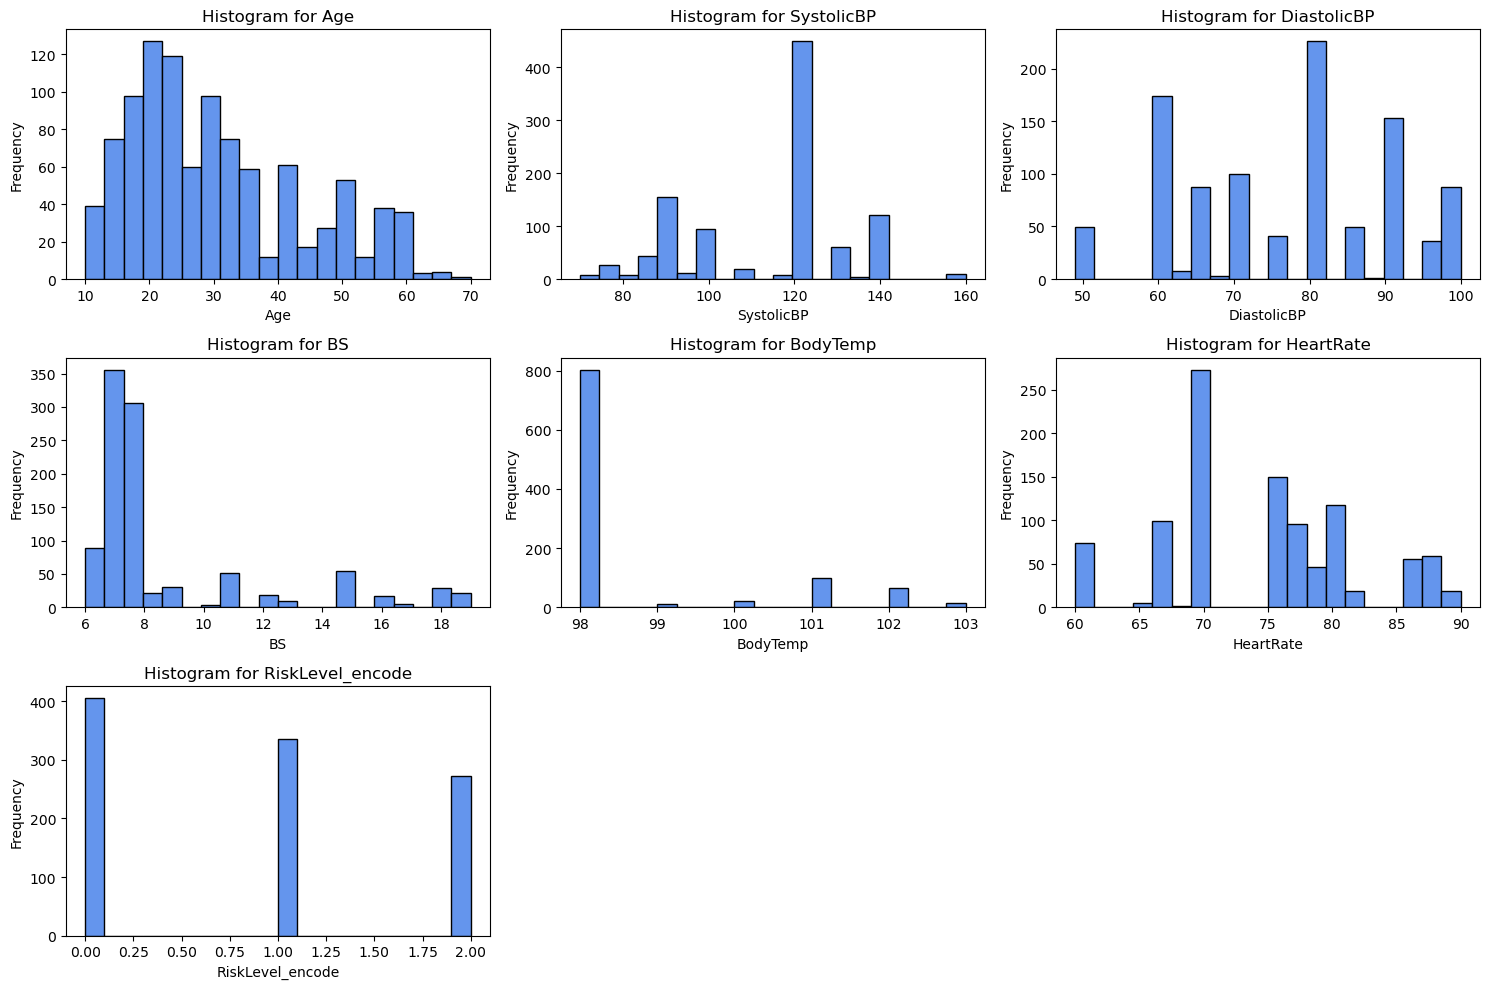

In [17]:
# Visualize skewness using histogram for each numerical feature

num_cols = df.select_dtypes(include='number').columns

plt.figure(figsize=(15, 10))
for i, column in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[column].dropna(), bins=20, edgecolor='k', color='cornflowerblue')
    plt.title(f'Histogram for {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


***Histogram Observation***


- From the above it is seen that BS and Body Temp are highly skewed. BS and Body Temp are positively skewed.Age is moderately skewed. Diastolic, systolic, and HeartRate are approximately symmetric

### 5.5. Box plot for visualizing presence of outliers

- The presence of outliers in a dataset can significantly impact model performance as extreme values or very low values can affect our model ability to classify instances and potentially leading to poor generalization and bias.

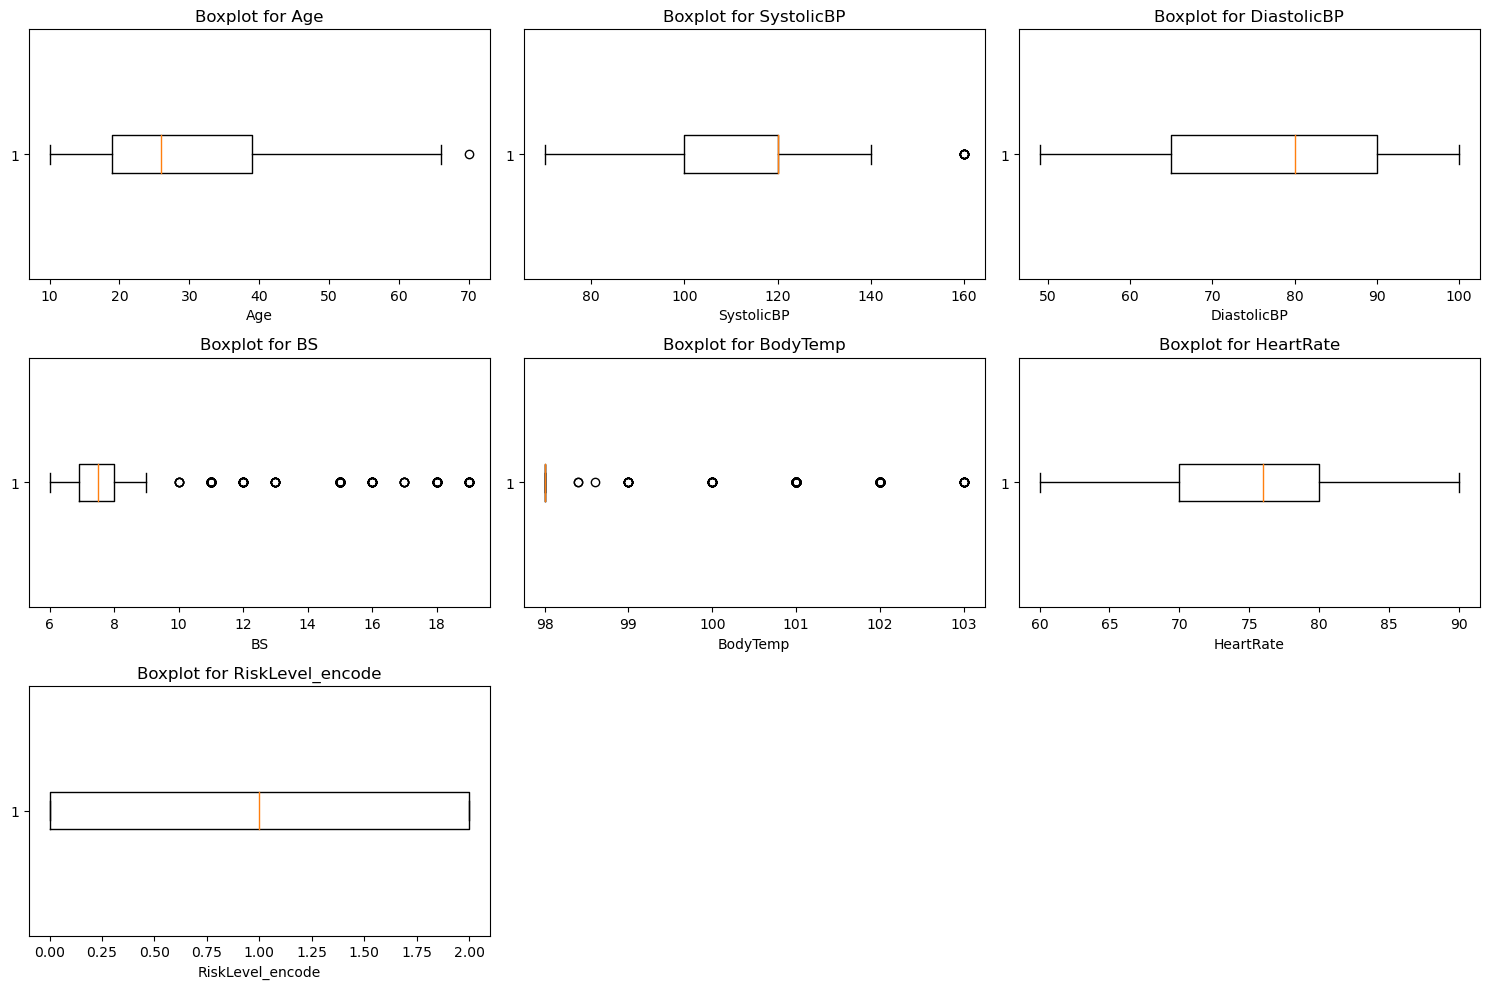

In [18]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(num_cols, 1):
    plt.subplot(3, 3, i)
    plt.boxplot(df[column].dropna(), vert=False)
    plt.title(f'Boxplot for {column}')
    plt.xlabel(column)
plt.tight_layout()
plt.show()

***Box plot observation***

- BS and BodyTemp have the highest number of outliers, indicating that they contain values that are either extremely high or extremely low compared to the concentration of other data points.


### 5.6. Pairplot of some correlated features

<Figure size 1000x500 with 0 Axes>

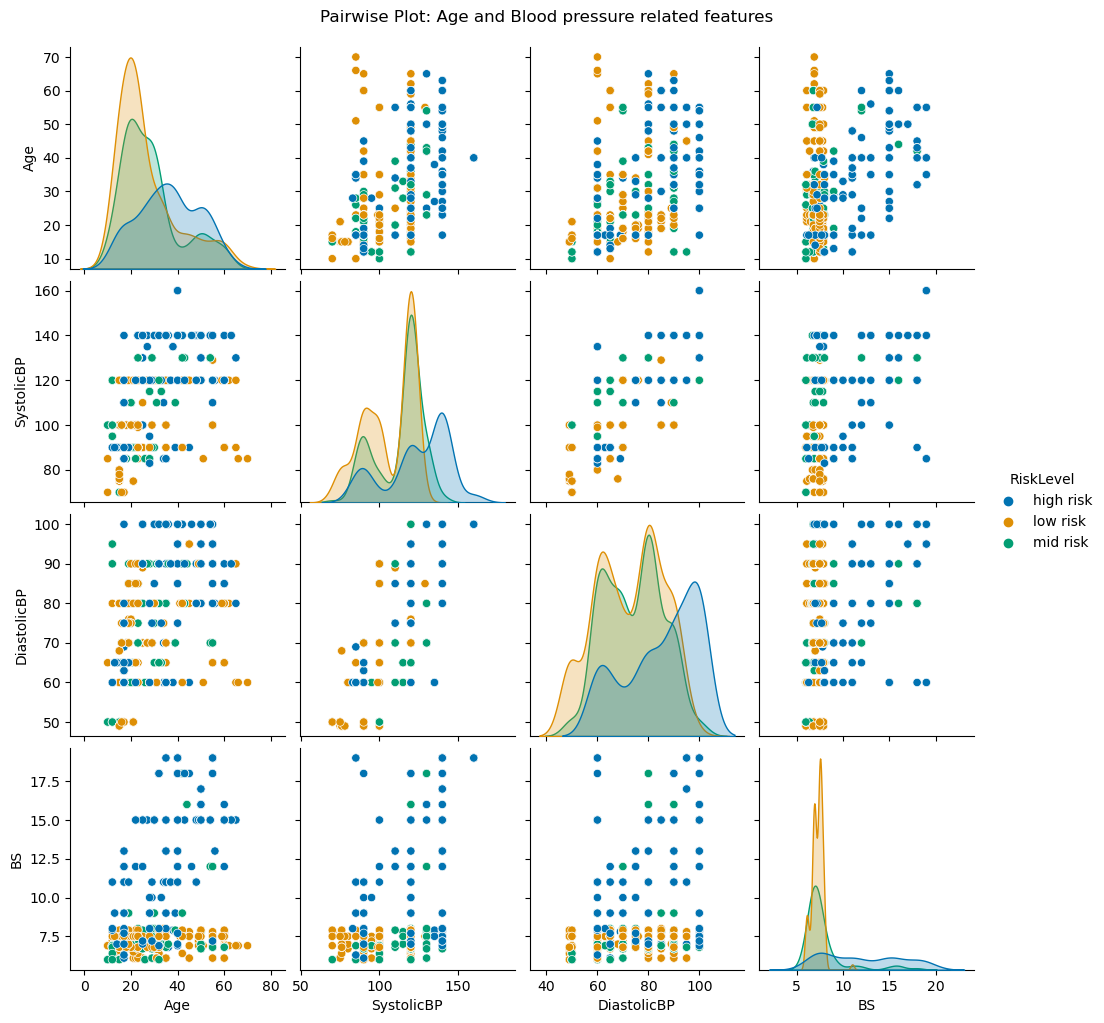

In [19]:
warnings.filterwarnings('ignore')

# Define feature sets
features_1 = ['Age', 'SystolicBP', 'DiastolicBP', 'BS']

# Pairwise plot 
plt.figure(figsize=(10, 5))
sns.pairplot(df, vars=features_1, hue='RiskLevel', palette='colorblind')
plt.suptitle('Pairwise Plot: Age and Blood pressure related features', y=1.02)
plt.show();



***Pair Plot Observation***
- There is a linear relationship between diastolicBP and systolicBP. This shows that as one increase, the other increases too.
- Age has no linear relationship with other features. Suggesting that risk in preganacy is not solely dependent on age but likely influenced by other factors
- The higher the Blood sugar, the more likelihood of a high risk pregnancy

## 6. Feature Engineering
The below feature engineering will be performed. N/B we will still retain our original data as our model building will utilize the original data and feature engineered data.
- create a new feature called MAP using the systolic and Diastolic BP feature
- Use Box-Cox transofrmation on Age and BS features that are positively skewed to achieve a more Guassian-like distribution.This ensures that our model performance is not adversely influenced by the presence of extreme values causing the positive skewness. Note that we will not transform the BodyTemp features as the data points range is narrow. 

In [20]:
# Make a copy of our original data as we need it for experimenting.
df_or = df.copy()

In [21]:
# Calculate Mean Arterial Pressure (MAP)
df['MAP'] = df['DiastolicBP'] + (1/3) * (df['SystolicBP'] - df['DiastolicBP'])

In [22]:
# Box-Cox transformation 
df['Age_Tr'], _ = boxcox(df['Age']) 
df['BS_Tr'], _ = boxcox(df['BS'])

print(df)

      Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel  \
0      25         130           80  15.0      98.0         86  high risk   
1      35         140           90  13.0      98.0         70  high risk   
2      29          90           70   8.0     100.0         80  high risk   
3      30         140           85   7.0      98.0         70  high risk   
4      35         120           60   6.1      98.0         76   low risk   
...   ...         ...          ...   ...       ...        ...        ...   
1009   22         120           60  15.0      98.0         80  high risk   
1010   55         120           90  18.0      98.0         60  high risk   
1011   35          85           60  19.0      98.0         86  high risk   
1012   43         120           90  18.0      98.0         70  high risk   
1013   32         120           65   6.0     101.0         76   mid risk   

      RiskLevel_encode         MAP    Age_Tr     BS_Tr  
0                    2   96.66

In [23]:
# drop the original transformed features

df_transform = df.drop(['BS','Age'], axis=1)

## 7. Data Preprocessing
- It is essential to preprocess the data so as to ensure that the data is clean, well-formatted, and ready for model training.
This process when carefully done leads to more accurate and reliable results.

- **The following preprocessing will be applied:**
    - **identify and handle anomalies if any**
    - **Feature-target separation**
    - **Encode Categorical features where applicable**
    - **Scale and standardize features**
    - **Split data**
    

### 7.1. Identify and handle anomalies(where applicable)
- it has been established that our data does not contain any missing values. 

### 7.2. Feature-Target Separation
- **The target variable(Y) will be separated from the independent variables(X)**
- The target variable is the output our model will aim to predict.
- The independent variables will be the input our model will use to learn patterns and make predictions.

### 7.3. Encode Categorical features
It is essential for us to transform our categorical data to numerical for easy interpretabilty by our model as most model require numerical input. This ensures that the model can process the data effectively, leading to improved performance and accuracy.Following the mapping of our target variable, we will not perform any new encoding on my target variable

### 7.4. Split Data
- **Train and Test:** Our data will be split into training and testing sets, The training will be used training the model. The test set will be used to evaluate our model's performance on unseen data(test set).
- **Random state:** The random state will be set to a fixed interger. This ensures reproductivity meaning that for every time the code is ran, the split between the training and testing remains the same.
- **Stratification:** stratifying the target variable(y) ensures that the class distribution of the test and train will closely match that of the original data class distribution

### 7.5. Scale and Standardize the independent features(X)
it is important to scale/standardize our data before feeding it to a model as this helps to ensure that all features contribute equally to the model performance and prevents features with larger values to dominate the model learning process. 

## 8.0 Model building
We will utilize scikit-learn libraries and tensor flow in building our model. 
- **Scikit-learn** will be used in building the selected model
- **Tensor flow** we will use it to build a fastforward neural network model

We will implore 2 methods in buiding our model
- **Method 1** use the original data set
- **Method 2** use the feature-engineered data set

For both methods, the process flow remains the same and that is

1) prepare our data for use in the model
2) train traditional models, select the best performer and hypertune
3) train FNN model
4) combine predictions of the best traditional model and fnn model and train a meta model on it.
5) Evaluate results obtained from (2), (3) and (4). 

Using this two methods, the best model or stage that ticks all evaluation metrics becomes our selected model



### 8.1. Method 1.Using original dataset


### 8.1.1. Train selected traditional models

In [24]:
# perform feature separation

X = df_or.drop(['RiskLevel','RiskLevel_encode'],axis=1)
y = df_or['RiskLevel_encode']

In [25]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123, stratify=y)

In [26]:
# instantiate our scaling method
scaler_or = StandardScaler()

# feed the independent variables(X) to our scaler
X_train_or = scaler_or.fit_transform(X_train)
X_test_or = scaler_or.transform(X_test)

In [27]:
# selection of our traditional model

models_or = [[RandomForestClassifier(random_state=42), 'Random Forest'],
               [XGBClassifier(random_state=42), 'XGB Classifier'],
               [ExtraTreesClassifier(random_state=42), 'ET Classifier'],
               [CatBoostClassifier(random_state=42), 'CB Classifier']]

In [28]:
# set up evaluation metrics
metrics_or = {'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'ROC AUC Score': []
}

In [29]:
# Run the training loop
for model, model_name in models_or:
    #fit the model
    model.fit(X_train_or, y_train)
   
    #evaluate the model
    pred_or = model.predict(X_test_or)
    
    acc_score_or = accuracy_score(y_test, pred_or)
    pre_score_or = precision_score(y_test, pred_or, average='macro')
    recal_score_or = recall_score(y_test, pred_or, average='macro')
    roc_score_or = roc_auc_score(y_test, model.predict_proba(X_test_or), multi_class='ovr')
    
    # Store metrics
    metrics_or['Model'].append(model_name)
    metrics_or['Accuracy'].append(f"{round(acc_score_or * 100, 2)}%")
    metrics_or['Precision'].append(f"{round(pre_score_or * 100, 2)}%")
    metrics_or['Recall'].append(f"{round(recal_score_or * 100, 2)}%")
    metrics_or['ROC AUC Score'].append(f"{round(roc_score_or * 100, 2)}%")
    
    if model_name != models_or[-1][1]:
        print(f"Evaluated {model_name}")
        
warnings.filterwarnings('ignore', category=UserWarning)

Evaluated Random Forest
Evaluated XGB Classifier
Evaluated ET Classifier
Learning rate set to 0.078286
0:	learn: 1.0504113	total: 138ms	remaining: 2m 17s
1:	learn: 1.0079825	total: 142ms	remaining: 1m 10s
2:	learn: 0.9758851	total: 144ms	remaining: 47.9s
3:	learn: 0.9446884	total: 149ms	remaining: 37s
4:	learn: 0.9175699	total: 152ms	remaining: 30.3s
5:	learn: 0.8932205	total: 155ms	remaining: 25.7s
6:	learn: 0.8729507	total: 158ms	remaining: 22.4s
7:	learn: 0.8521010	total: 160ms	remaining: 19.9s
8:	learn: 0.8327517	total: 163ms	remaining: 17.9s
9:	learn: 0.8132963	total: 164ms	remaining: 16.3s
10:	learn: 0.7992688	total: 166ms	remaining: 14.9s
11:	learn: 0.7836890	total: 168ms	remaining: 13.8s
12:	learn: 0.7716959	total: 169ms	remaining: 12.8s
13:	learn: 0.7600952	total: 171ms	remaining: 12s
14:	learn: 0.7489627	total: 172ms	remaining: 11.3s
15:	learn: 0.7367291	total: 173ms	remaining: 10.7s
16:	learn: 0.7266932	total: 177ms	remaining: 10.2s
17:	learn: 0.7188279	total: 179ms	remainin

282:	learn: 0.3098820	total: 554ms	remaining: 1.4s
283:	learn: 0.3093827	total: 556ms	remaining: 1.4s
284:	learn: 0.3090694	total: 558ms	remaining: 1.4s
285:	learn: 0.3087231	total: 560ms	remaining: 1.4s
286:	learn: 0.3084624	total: 562ms	remaining: 1.4s
287:	learn: 0.3081391	total: 563ms	remaining: 1.39s
288:	learn: 0.3076374	total: 565ms	remaining: 1.39s
289:	learn: 0.3072566	total: 566ms	remaining: 1.39s
290:	learn: 0.3069281	total: 568ms	remaining: 1.38s
291:	learn: 0.3066752	total: 569ms	remaining: 1.38s
292:	learn: 0.3063343	total: 570ms	remaining: 1.38s
293:	learn: 0.3060712	total: 572ms	remaining: 1.37s
294:	learn: 0.3057347	total: 573ms	remaining: 1.37s
295:	learn: 0.3054541	total: 574ms	remaining: 1.37s
296:	learn: 0.3052088	total: 576ms	remaining: 1.36s
297:	learn: 0.3049418	total: 577ms	remaining: 1.36s
298:	learn: 0.3047386	total: 578ms	remaining: 1.35s
299:	learn: 0.3044994	total: 580ms	remaining: 1.35s
300:	learn: 0.3040523	total: 581ms	remaining: 1.35s
301:	learn: 0.303

480:	learn: 0.2531105	total: 937ms	remaining: 1.01s
481:	learn: 0.2528174	total: 939ms	remaining: 1.01s
482:	learn: 0.2526276	total: 941ms	remaining: 1.01s
483:	learn: 0.2524550	total: 943ms	remaining: 1s
484:	learn: 0.2521221	total: 946ms	remaining: 1s
485:	learn: 0.2518885	total: 948ms	remaining: 1s
486:	learn: 0.2517348	total: 950ms	remaining: 1s
487:	learn: 0.2515527	total: 953ms	remaining: 1000ms
488:	learn: 0.2514424	total: 955ms	remaining: 998ms
489:	learn: 0.2510435	total: 957ms	remaining: 996ms
490:	learn: 0.2508427	total: 960ms	remaining: 995ms
491:	learn: 0.2505384	total: 962ms	remaining: 994ms
492:	learn: 0.2503295	total: 964ms	remaining: 991ms
493:	learn: 0.2501834	total: 966ms	remaining: 989ms
494:	learn: 0.2500896	total: 967ms	remaining: 987ms
495:	learn: 0.2498850	total: 969ms	remaining: 985ms
496:	learn: 0.2497163	total: 971ms	remaining: 982ms
497:	learn: 0.2494735	total: 972ms	remaining: 980ms
498:	learn: 0.2492650	total: 974ms	remaining: 978ms
499:	learn: 0.2490768	t

642:	learn: 0.2260719	total: 1.31s	remaining: 728ms
643:	learn: 0.2259960	total: 1.31s	remaining: 726ms
644:	learn: 0.2258163	total: 1.31s	remaining: 723ms
645:	learn: 0.2257005	total: 1.32s	remaining: 722ms
646:	learn: 0.2255502	total: 1.32s	remaining: 720ms
647:	learn: 0.2254851	total: 1.32s	remaining: 718ms
648:	learn: 0.2253644	total: 1.32s	remaining: 716ms
649:	learn: 0.2253107	total: 1.33s	remaining: 716ms
650:	learn: 0.2252243	total: 1.33s	remaining: 714ms
651:	learn: 0.2250747	total: 1.33s	remaining: 712ms
652:	learn: 0.2249209	total: 1.33s	remaining: 710ms
653:	learn: 0.2248761	total: 1.34s	remaining: 707ms
654:	learn: 0.2248025	total: 1.34s	remaining: 705ms
655:	learn: 0.2246873	total: 1.34s	remaining: 703ms
656:	learn: 0.2245464	total: 1.34s	remaining: 702ms
657:	learn: 0.2244508	total: 1.34s	remaining: 699ms
658:	learn: 0.2243094	total: 1.35s	remaining: 697ms
659:	learn: 0.2241584	total: 1.35s	remaining: 695ms
660:	learn: 0.2239657	total: 1.35s	remaining: 693ms
661:	learn: 

864:	learn: 0.2067846	total: 1.68s	remaining: 262ms
865:	learn: 0.2067070	total: 1.68s	remaining: 260ms
866:	learn: 0.2066351	total: 1.68s	remaining: 258ms
867:	learn: 0.2065251	total: 1.69s	remaining: 256ms
868:	learn: 0.2064465	total: 1.69s	remaining: 254ms
869:	learn: 0.2063518	total: 1.69s	remaining: 252ms
870:	learn: 0.2062643	total: 1.69s	remaining: 250ms
871:	learn: 0.2062149	total: 1.69s	remaining: 248ms
872:	learn: 0.2061618	total: 1.69s	remaining: 246ms
873:	learn: 0.2061314	total: 1.69s	remaining: 244ms
874:	learn: 0.2060920	total: 1.7s	remaining: 242ms
875:	learn: 0.2060047	total: 1.7s	remaining: 240ms
876:	learn: 0.2059169	total: 1.7s	remaining: 238ms
877:	learn: 0.2058414	total: 1.7s	remaining: 236ms
878:	learn: 0.2058029	total: 1.7s	remaining: 234ms
879:	learn: 0.2057496	total: 1.7s	remaining: 232ms
880:	learn: 0.2057119	total: 1.71s	remaining: 230ms
881:	learn: 0.2056343	total: 1.71s	remaining: 228ms
882:	learn: 0.2055522	total: 1.71s	remaining: 226ms
883:	learn: 0.2054

In [30]:
# Create DataFrame from metrics dictionary
metrics_or_df = pd.DataFrame(metrics_or)

metrics_or_df

,Model,Accuracy,Precision,Recall,ROC AUC Score
0,Random Forest,87.19%,87.45%,87.34%,96.59%
1,XGB Classifier,86.21%,86.33%,86.26%,96.7%
2,ET Classifier,85.71%,85.66%,86.02%,96.07%
3,CB Classifier,86.7%,86.89%,86.82%,96.41%


***Observation from traditional model building using original data***
- Random Forest classifier emerged as the best performed model. 

In [31]:
# Define the hyperparameter space
param_rf = {
   'n_estimators': Integer(10, 200),                # Number of trees in the forest
    'max_depth': Integer(1, 50),                     # Maximum depth of the trees
    'min_samples_split': Integer(2, 20),              # Minimum number of samples required to split an internal node
    'min_samples_leaf': Integer(1, 20),               # Minimum number of samples required to be at a leaf node
    'max_features': Real(0.1, 1.0, prior='uniform')  # Number of features to consider when looking for the best split
}

In [32]:
# Create the BayesSearchCV object
bayes_rf=BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=param_rf,
    n_iter=100,  # Number of iterations
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),       # Number of cross-validation folds
    scoring='accuracy',
    n_jobs=-1,  # Use all available cores
    random_state=42
)

In [33]:
# Fit the optimizer
rf_fit =bayes_rf.fit(X_train_or, y_train)

In [34]:
# Get the best parameters and best score
best_params_rf = rf_fit.best_params_
best_score_rf = rf_fit.best_score_

print(f"Best Parameters: {best_params_rf}")
print(f"Best Cross-Validation Accuracy: {best_score_rf:.4f}")

Best Parameters: OrderedDict([('max_depth', 16), ('max_features', 1.0), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])
Best Cross-Validation Accuracy: 0.8287


In [35]:
# Train the final model with the best parameters
model_rf_or = RandomForestClassifier(**best_params_rf, random_state=42)
model_rf_or.fit(X_train_or, y_train)

RandomForestClassifier(max_depth=16, max_features=1.0, n_estimators=200,
                       random_state=42)

In [36]:
#Predict on the train set
rf_train_pred = model_rf_or.predict(X_train_or)

#get training prediction probabilities
rf_train_prob = model_rf_or.predict_proba(X_train_or)

# Predict on the test set
rf_test_pred = model_rf_or.predict(X_test_or)

#get prediction probabilities
rf_test_prob = model_rf_or.predict_proba(X_test_or)



In [37]:
#Evaluate the model performance
rf_classification_rep = classification_report(y_test, rf_test_pred)
rf_auc = roc_auc_score(pd.get_dummies(y_test), rf_test_prob, multi_class='ovo', average='macro')

print("Classification Report:Random Forest Classifier on Original Data")
print(rf_classification_rep)
print("AUC score: Random Forest Classifier on Original Data")
print(rf_auc)

Classification Report:Random Forest Classifier on Original Data
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        81
           1       0.85      0.93      0.89        67
           2       0.91      0.87      0.89        55

    accuracy                           0.89       203
   macro avg       0.89      0.89      0.89       203
weighted avg       0.89      0.89      0.89       203

AUC score: Random Forest Classifier on Original Data
0.9696854479718127


### 8.1.2. Build FNN model

In [38]:
# Set the random seed for reproducibility
random_seed = 42
tf.random.set_seed(random_seed)

def build_fnn(input_shape):
    model = tf.keras.models.Sequential()
    
    # Input layer and first hidden layer
    model.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(0.0001)))
    model.add(tf.keras.layers.Dropout(0.2))  
    
    # Second hidden layer
    model.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(tf.keras.layers.Dropout(0.2))  
    
    # Third hidden layer
    model.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=l2(0.0001)))
    model.add(tf.keras.layers.Dropout(0.2))  
    
    # Output layer for multiclass classification
    model.add(tf.keras.layers.Dense(3, activation='softmax')) 

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


In [39]:
# Train on the fnn model
fnn_model_or = build_fnn(X_train_or.shape[1])
history_or = fnn_model_or.fit(X_train_or, y_train, epochs=400, batch_size=32, 
                              validation_data =(X_test_or,y_test), verbose=2)

Epoch 1/400
26/26 - 4s - 169ms/step - accuracy: 0.4044 - loss: 1.0903 - val_accuracy: 0.4877 - val_loss: 1.0596
Epoch 2/400
26/26 - 0s - 5ms/step - accuracy: 0.4427 - loss: 1.0708 - val_accuracy: 0.5911 - val_loss: 1.0355
Epoch 3/400
26/26 - 0s - 4ms/step - accuracy: 0.4735 - loss: 1.0487 - val_accuracy: 0.6256 - val_loss: 1.0145
Epoch 4/400
26/26 - 0s - 4ms/step - accuracy: 0.5302 - loss: 1.0264 - val_accuracy: 0.6355 - val_loss: 0.9932
Epoch 5/400
26/26 - 0s - 5ms/step - accuracy: 0.5512 - loss: 1.0087 - val_accuracy: 0.6305 - val_loss: 0.9722
Epoch 6/400
26/26 - 0s - 4ms/step - accuracy: 0.5647 - loss: 0.9878 - val_accuracy: 0.6158 - val_loss: 0.9527
Epoch 7/400
26/26 - 0s - 4ms/step - accuracy: 0.5598 - loss: 0.9907 - val_accuracy: 0.6256 - val_loss: 0.9359
Epoch 8/400
26/26 - 0s - 4ms/step - accuracy: 0.5635 - loss: 0.9611 - val_accuracy: 0.6305 - val_loss: 0.9198
Epoch 9/400
26/26 - 0s - 4ms/step - accuracy: 0.5820 - loss: 0.9476 - val_accuracy: 0.6256 - val_loss: 0.9049
Epoch 10

Epoch 75/400
26/26 - 0s - 4ms/step - accuracy: 0.6843 - loss: 0.7077 - val_accuracy: 0.6946 - val_loss: 0.7067
Epoch 76/400
26/26 - 0s - 4ms/step - accuracy: 0.6720 - loss: 0.6872 - val_accuracy: 0.6946 - val_loss: 0.7061
Epoch 77/400
26/26 - 0s - 4ms/step - accuracy: 0.6819 - loss: 0.6779 - val_accuracy: 0.6946 - val_loss: 0.7055
Epoch 78/400
26/26 - 0s - 4ms/step - accuracy: 0.6856 - loss: 0.6947 - val_accuracy: 0.6946 - val_loss: 0.7052
Epoch 79/400
26/26 - 0s - 4ms/step - accuracy: 0.6658 - loss: 0.6918 - val_accuracy: 0.6946 - val_loss: 0.7045
Epoch 80/400
26/26 - 0s - 4ms/step - accuracy: 0.6769 - loss: 0.6757 - val_accuracy: 0.6946 - val_loss: 0.7045
Epoch 81/400
26/26 - 0s - 4ms/step - accuracy: 0.6880 - loss: 0.6971 - val_accuracy: 0.6946 - val_loss: 0.7044
Epoch 82/400
26/26 - 0s - 4ms/step - accuracy: 0.6819 - loss: 0.6809 - val_accuracy: 0.6946 - val_loss: 0.7036
Epoch 83/400
26/26 - 0s - 4ms/step - accuracy: 0.6769 - loss: 0.7056 - val_accuracy: 0.6946 - val_loss: 0.7034
E

Epoch 149/400
26/26 - 0s - 4ms/step - accuracy: 0.6880 - loss: 0.6481 - val_accuracy: 0.7044 - val_loss: 0.6817
Epoch 150/400
26/26 - 0s - 4ms/step - accuracy: 0.6954 - loss: 0.6515 - val_accuracy: 0.7044 - val_loss: 0.6812
Epoch 151/400
26/26 - 0s - 4ms/step - accuracy: 0.6745 - loss: 0.6503 - val_accuracy: 0.7044 - val_loss: 0.6811
Epoch 152/400
26/26 - 0s - 4ms/step - accuracy: 0.7102 - loss: 0.6487 - val_accuracy: 0.6995 - val_loss: 0.6810
Epoch 153/400
26/26 - 0s - 4ms/step - accuracy: 0.6905 - loss: 0.6525 - val_accuracy: 0.7044 - val_loss: 0.6806
Epoch 154/400
26/26 - 0s - 4ms/step - accuracy: 0.7189 - loss: 0.6419 - val_accuracy: 0.7044 - val_loss: 0.6800
Epoch 155/400
26/26 - 0s - 4ms/step - accuracy: 0.6868 - loss: 0.6508 - val_accuracy: 0.7044 - val_loss: 0.6798
Epoch 156/400
26/26 - 0s - 4ms/step - accuracy: 0.6942 - loss: 0.6706 - val_accuracy: 0.7044 - val_loss: 0.6791
Epoch 157/400
26/26 - 0s - 4ms/step - accuracy: 0.6720 - loss: 0.6497 - val_accuracy: 0.6995 - val_loss:

Epoch 223/400
26/26 - 0s - 5ms/step - accuracy: 0.7041 - loss: 0.6240 - val_accuracy: 0.7094 - val_loss: 0.6695
Epoch 224/400
26/26 - 0s - 5ms/step - accuracy: 0.6954 - loss: 0.6258 - val_accuracy: 0.7241 - val_loss: 0.6687
Epoch 225/400
26/26 - 0s - 4ms/step - accuracy: 0.7028 - loss: 0.6333 - val_accuracy: 0.7192 - val_loss: 0.6690
Epoch 226/400
26/26 - 0s - 4ms/step - accuracy: 0.7078 - loss: 0.6280 - val_accuracy: 0.7192 - val_loss: 0.6693
Epoch 227/400
26/26 - 0s - 4ms/step - accuracy: 0.7189 - loss: 0.6143 - val_accuracy: 0.7094 - val_loss: 0.6692
Epoch 228/400
26/26 - 0s - 4ms/step - accuracy: 0.7078 - loss: 0.6264 - val_accuracy: 0.7094 - val_loss: 0.6684
Epoch 229/400
26/26 - 0s - 4ms/step - accuracy: 0.7065 - loss: 0.6137 - val_accuracy: 0.7192 - val_loss: 0.6679
Epoch 230/400
26/26 - 0s - 4ms/step - accuracy: 0.7201 - loss: 0.6231 - val_accuracy: 0.7192 - val_loss: 0.6679
Epoch 231/400
26/26 - 0s - 4ms/step - accuracy: 0.7016 - loss: 0.6407 - val_accuracy: 0.7192 - val_loss:

Epoch 296/400
26/26 - 0s - 6ms/step - accuracy: 0.7102 - loss: 0.6032 - val_accuracy: 0.7241 - val_loss: 0.6604
Epoch 297/400
26/26 - 0s - 7ms/step - accuracy: 0.7078 - loss: 0.6140 - val_accuracy: 0.7241 - val_loss: 0.6600
Epoch 298/400
26/26 - 0s - 6ms/step - accuracy: 0.6991 - loss: 0.6136 - val_accuracy: 0.7241 - val_loss: 0.6591
Epoch 299/400
26/26 - 0s - 5ms/step - accuracy: 0.7250 - loss: 0.6090 - val_accuracy: 0.7192 - val_loss: 0.6586
Epoch 300/400
26/26 - 0s - 6ms/step - accuracy: 0.7078 - loss: 0.6112 - val_accuracy: 0.7192 - val_loss: 0.6580
Epoch 301/400
26/26 - 0s - 4ms/step - accuracy: 0.7263 - loss: 0.6073 - val_accuracy: 0.7192 - val_loss: 0.6577
Epoch 302/400
26/26 - 0s - 4ms/step - accuracy: 0.7176 - loss: 0.6002 - val_accuracy: 0.7192 - val_loss: 0.6567
Epoch 303/400
26/26 - 0s - 5ms/step - accuracy: 0.7226 - loss: 0.5989 - val_accuracy: 0.7192 - val_loss: 0.6562
Epoch 304/400
26/26 - 0s - 4ms/step - accuracy: 0.6967 - loss: 0.6216 - val_accuracy: 0.7241 - val_loss:

26/26 - 0s - 4ms/step - accuracy: 0.7127 - loss: 0.6017 - val_accuracy: 0.7192 - val_loss: 0.6522
Epoch 370/400
26/26 - 0s - 4ms/step - accuracy: 0.7016 - loss: 0.6008 - val_accuracy: 0.7192 - val_loss: 0.6525
Epoch 371/400
26/26 - 0s - 4ms/step - accuracy: 0.6942 - loss: 0.6070 - val_accuracy: 0.7192 - val_loss: 0.6519
Epoch 372/400
26/26 - 0s - 4ms/step - accuracy: 0.7115 - loss: 0.5955 - val_accuracy: 0.7192 - val_loss: 0.6509
Epoch 373/400
26/26 - 0s - 5ms/step - accuracy: 0.7115 - loss: 0.6000 - val_accuracy: 0.7192 - val_loss: 0.6498
Epoch 374/400
26/26 - 0s - 4ms/step - accuracy: 0.7201 - loss: 0.5941 - val_accuracy: 0.7192 - val_loss: 0.6494
Epoch 375/400
26/26 - 0s - 4ms/step - accuracy: 0.7115 - loss: 0.5956 - val_accuracy: 0.7192 - val_loss: 0.6500
Epoch 376/400
26/26 - 0s - 4ms/step - accuracy: 0.7164 - loss: 0.5891 - val_accuracy: 0.7192 - val_loss: 0.6500
Epoch 377/400
26/26 - 0s - 4ms/step - accuracy: 0.7127 - loss: 0.5909 - val_accuracy: 0.7192 - val_loss: 0.6504
Epoch 

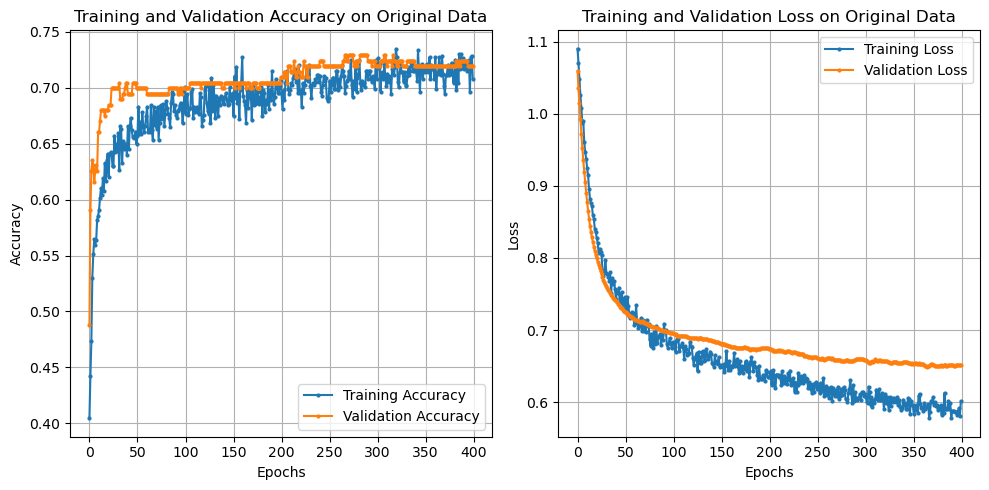

In [40]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_or.history['accuracy'], label='Training Accuracy', marker='o', linestyle='-', markersize=2)
plt.plot(history_or.history['val_accuracy'], label='Validation Accuracy', marker='o', linestyle='-', markersize=2)
plt.title('Training and Validation Accuracy on Original Data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_or.history['loss'], label='Training Loss', marker='o', linestyle='-', markersize=2)
plt.plot(history_or.history['val_loss'], label='Validation Loss', marker='o', linestyle='-', markersize=2)
plt.title('Training and Validation Loss on Original Data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [41]:
# Save the trained model
fnn_model_or = fnn_model_or.save('fnn_model_or.keras')

In [42]:
# Load the saved model
fnn_model_or = load_model('fnn_model_or.keras')

In [43]:
#Get training predictions probabilities
fnn_train_pred_or = fnn_model_or.predict(X_train_or)

#convert training predictions to classes
fnn_train_prob_or = np.argmax(fnn_train_pred_or, axis=1)

# Get test predictions probabilities
fnn_test_pred_or = fnn_model_or.predict(X_test_or) 

# convert prediction to classes
fnn_test_prob_or = np.argmax(fnn_test_pred_or, axis=1) 


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [44]:
#Evaluate the model performance
fnn_classification_rep_or = classification_report(y_test, fnn_test_prob_or)
fnn_auc = roc_auc_score(pd.get_dummies(y_test), fnn_test_pred_or, multi_class='ovo', average='macro')

print("Classification Report:FNN model on the Original Data")
print(fnn_classification_rep_or)
print("AUC score: FNN model on the Original Data")
print(fnn_auc)

Classification Report:FNN model on the Original Data
              precision    recall  f1-score   support

           0       0.68      0.89      0.77        81
           1       0.71      0.43      0.54        67
           2       0.80      0.82      0.81        55

    accuracy                           0.72       203
   macro avg       0.73      0.71      0.71       203
weighted avg       0.72      0.72      0.70       203

AUC score: FNN model on the Original Data
0.8817321806720483


### 8.1.3. Ensemble predictions of the RF and FNN model and Evaluate 

In [45]:
# Make a dataframe of FNN predictions
fnn_predictions_or = pd.DataFrame(fnn_test_pred_or, columns=['Score_0', 'Score_1', 'Score_2'])
fnn_predictions_or['Label'] = fnn_predictions_or.idxmax(axis=1).str.replace('Score_', '').astype(int)

In [46]:
# Make a dataframe of RF predictions
rf_pred_df = pd.DataFrame(rf_test_pred, columns=['Label'])

# Make a dataframe of probabilities
rf_prob_df = pd.DataFrame(rf_test_prob, columns=['Score_0', 'Score_1', 'Score_2'])

# Concatenate the predictions and probabilities DataFrames
rf_predictions_or = pd.concat([rf_pred_df, rf_prob_df], axis=1)

In [47]:
#Ensure both predictions DataFrames have the same index
rf_predictions_or = rf_predictions_or.reset_index(drop=True)
fnn_predictions_or = fnn_predictions_or.reset_index(drop=True)

In [48]:
# Extract necessary columns for probabilities
rf_probs = rf_predictions_or[['Score_0', 'Score_1', 'Score_2']]
fnn_probs = fnn_predictions_or[['Score_0', 'Score_1', 'Score_2']]

In [49]:
# Average the probabilities from both models
ensemble_probs = (rf_probs.values + fnn_probs.values) / 2

# Check that the combined probabilities sum to 1
assert np.allclose(ensemble_probs.sum(axis=1), 1), "Probabilities should sum to 1 for each sample"

# Determine the final predicted class based on the maximum combined probability
ensemble_pred = np.argmax(ensemble_probs, axis=1)

In [50]:
# Evaluate the model on our unseen data(y_test)
ensemble_classification_rep = classification_report(y_test, ensemble_pred)
ensemble_auc = roc_auc_score(pd.get_dummies(y_test), ensemble_probs, multi_class='ovo', average='macro')


print("Classification Report:Ensemble predictions of FNN and RF On original data using soft voting")
print(ensemble_classification_rep)
print("AUC score: Ensemble predictions on Original Data")
print(ensemble_auc)


Classification Report:Ensemble predictions of FNN and RF On original data using soft voting
              precision    recall  f1-score   support

           0       0.85      0.88      0.86        81
           1       0.82      0.82      0.82        67
           2       0.90      0.85      0.88        55

    accuracy                           0.85       203
   macro avg       0.86      0.85      0.85       203
weighted avg       0.85      0.85      0.85       203

AUC score: Ensemble predictions on Original Data
0.9606293517536683


### 8.1.4. Ensemble predictions of train and test data and use it as features and train a meta model

In [51]:
# Combine the predictions from base models for training data
X_train_meta_or = np.column_stack([rf_train_prob, fnn_train_pred_or])
y_train_meta_or = y_train  # Target labels for the meta-model

# Combine predictions from base models for test data
X_test_meta_or = np.column_stack([rf_test_prob, fnn_test_pred_or])

In [52]:
# selection of our meta model

models_meta_or = [[LogisticRegression(random_state=42), 'Logistic Regression'],
               [XGBClassifier(random_state=42), 'XGB Classifier'],
               [ExtraTreesClassifier(random_state=42), 'ET Classifier'],
               [SVC(probability=True,random_state=42), 'SVC']]

In [53]:
# set up evaluation metrics
metrics_meta_or = {'Model_meta': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'ROC AUC Score': []
}

In [54]:
# Run the training loop
for model_meta, model_name_meta in models_meta_or:
    #fit the model
    model_meta.fit(X_train_meta_or, y_train_meta_or)
   
    #evaluate the model
    pred_meta_or = model_meta.predict(X_test_meta_or)
    
    acc_score_meta_or = accuracy_score(y_test, pred_meta_or)
    pre_score_meta_or = precision_score(y_test, pred_meta_or, average='macro')
    recal_score_meta_or = recall_score(y_test, pred_meta_or, average='macro')
    roc_score_meta_or = roc_auc_score(y_test, model_meta.predict_proba(X_test_meta_or), multi_class='ovr')
    
    # Store metrics
    metrics_meta_or['Model_meta'].append(model_name_meta)
    metrics_meta_or['Accuracy'].append(f"{round(acc_score_meta_or * 100, 2)}%")
    metrics_meta_or['Precision'].append(f"{round(pre_score_meta_or * 100, 2)}%")
    metrics_meta_or['Recall'].append(f"{round(recal_score_meta_or * 100, 2)}%")
    metrics_meta_or['ROC AUC Score'].append(f"{round(roc_score_meta_or * 100, 2)}%")
    
    if model_name_meta != models_meta_or[-1][1]:
        print(f"Evaluated {model_name_meta}")

warnings.filterwarnings('ignore', category=UserWarning)

Evaluated Logistic Regression
Evaluated XGB Classifier
Evaluated ET Classifier


In [55]:
# Create DataFrame from metrics dictionary
metrics_meta_or_df = pd.DataFrame(metrics_meta_or)

metrics_meta_or_df

,Model_meta,Accuracy,Precision,Recall,ROC AUC Score
0,Logistic Regression,88.18%,88.38%,88.07%,97.08%
1,XGB Classifier,86.21%,86.2%,86.26%,96.87%
2,ET Classifier,87.68%,87.91%,87.66%,96.66%
3,SVC,86.7%,86.8%,87.01%,94.0%


In [56]:
lr_model = LogisticRegression(multi_class='multinomial', penalty='l2', random_state=42)

In [57]:
# Define the hyperparameter space for the best performed meta-model
param_meta = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),  # Inverse of regularization strength
    'solver': Categorical(['lbfgs', 'newton-cg', 'saga'])  # Algorithm to use in the optimization problem
}

In [58]:
# Set up the BayesSearchCV
bayes_meta = BayesSearchCV(
    estimator=lr_model,
    search_spaces=param_meta,
    n_iter=100,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

In [59]:
# Fit the model
best_meta_or = bayes_meta.fit(X_train_meta_or, y_train_meta_or)

In [60]:
# Get the best parameters and best score
best_params_meta = best_meta_or.best_params_
best_score_meta = best_meta_or.best_score_

print(f"Best Parameters: {best_params_meta}")
print(f"Best Cross-Validation Accuracy: {best_score_meta:.4f}")

Best Parameters: OrderedDict([('C', 3.317697704417197), ('solver', 'saga')])
Best Cross-Validation Accuracy: 0.9211


In [61]:
#Re-initialise the model using the best parametr found
final_model_meta = LogisticRegression(**best_params_meta, multi_class='multinomial', penalty='l2', random_state=42)
final_model_meta.fit(X_train_meta_or, y_train_meta_or)

LogisticRegression(C=3.317697704417197, multi_class='multinomial',
                   random_state=42, solver='saga')

In [62]:
# Predict on the test set
y_pred_meta_or = final_model_meta.predict(X_test_meta_or)
y_prob_meta_or = final_model_meta.predict_proba(X_test_meta_or)


In [63]:
# Evaluate on the unseen data
meta_classification_rep = classification_report(y_test, y_pred_meta_or)
meta_auc = roc_auc_score(pd.get_dummies(y_test), y_prob_meta_or, multi_class='ovo', average='macro')


print("Classification Report:Meta Model(Logistic regression) on stacked predictions of FNN and RF on the Original data")
print(meta_classification_rep)
print("AUC score: Logistic regression on stacked predictions of FNN and RF on the Original Data")
print(meta_auc)

Classification Report:Meta Model(Logistic regression) on stacked predictions of FNN and RF on the Original data
              precision    recall  f1-score   support

           0       0.88      0.89      0.88        81
           1       0.87      0.88      0.87        67
           2       0.91      0.87      0.89        55

    accuracy                           0.88       203
   macro avg       0.88      0.88      0.88       203
weighted avg       0.88      0.88      0.88       203

AUC score: Logistic regression on stacked predictions of FNN and RF on the Original Data
0.9704343935547488


### 8.2. Method 2. Using feature-engineered data set

### 8.2.1. Train selected traditional models on the feature-engineered data

In [64]:
# perform feature separation

X_tr = df_transform.drop(['RiskLevel','RiskLevel_encode','BodyTemp'],axis=1)
y_tr = df_transform['RiskLevel_encode']

In [65]:
# Split the transformed data 
X_train_tr, X_test_tr, y_train_tr, y_test_tr = train_test_split(X_tr, y_tr, test_size=0.20, random_state=123, stratify=y_tr)

In [66]:
# instantiate our scaling method
scaler_tr = StandardScaler()

# feed the independent variables(X) to our scaler
X_train_tr_sca = scaler_tr.fit_transform(X_train_tr)
X_test_tr_sca = scaler_tr.transform(X_test_tr)

In [67]:
# selection of our traditional model

model_tr = [[RandomForestClassifier(random_state=42), 'Random Forest'],
               [XGBClassifier(random_state=42), 'XGB Classifier'],
               [ExtraTreesClassifier(random_state=42), 'ET Classifier'],
               [CatBoostClassifier(random_state=42), 'CB Classifier']]

In [68]:
metrics_tr = {'Model_tr': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'ROC AUC Score': []
}

In [69]:
warnings.filterwarnings('ignore')

# Run the training loop
for models_tr, model_name_tr in model_tr:
    #fit the model
    models_tr.fit(X_train_tr_sca, y_train_tr)
   
    #evaluate the model
    pred_tr = models_tr.predict(X_test_tr_sca)
    
    acc_score_tr = accuracy_score(y_test_tr, pred_tr)
    pre_score_tr = precision_score(y_test_tr, pred_tr, average='macro')
    recal_score_tr = recall_score(y_test_tr, pred_tr, average='macro')
    roc_score_tr = roc_auc_score(y_test_tr, models_tr.predict_proba(X_test_tr_sca), multi_class='ovr')
    
    # Store metrics
    metrics_tr['Model_tr'].append(model_name_tr)
    metrics_tr['Accuracy'].append(f"{round(acc_score_tr * 100, 2)}%")
    metrics_tr['Precision'].append(f"{round(pre_score_tr * 100, 2)}%")
    metrics_tr['Recall'].append(f"{round(recal_score_tr * 100, 2)}%")
    metrics_tr['ROC AUC Score'].append(f"{round(roc_score_tr * 100, 2)}%")
    
    if model_name_tr != model_tr[-1][1]:
        print(f"Evaluated {model_name_tr}")

Evaluated Random Forest
Evaluated XGB Classifier
Evaluated ET Classifier
Learning rate set to 0.078286
0:	learn: 1.0540592	total: 2.06ms	remaining: 2.06s
1:	learn: 1.0167525	total: 3.47ms	remaining: 1.73s
2:	learn: 0.9841566	total: 5ms	remaining: 1.66s
3:	learn: 0.9553527	total: 6.37ms	remaining: 1.59s
4:	learn: 0.9259966	total: 7.79ms	remaining: 1.55s
5:	learn: 0.9036507	total: 9.33ms	remaining: 1.54s
6:	learn: 0.8835938	total: 10.7ms	remaining: 1.52s
7:	learn: 0.8657794	total: 12.5ms	remaining: 1.55s
8:	learn: 0.8476961	total: 14ms	remaining: 1.54s
9:	learn: 0.8292015	total: 15.7ms	remaining: 1.55s
10:	learn: 0.8156747	total: 17.3ms	remaining: 1.55s
11:	learn: 0.7990233	total: 18.8ms	remaining: 1.55s
12:	learn: 0.7869975	total: 20.4ms	remaining: 1.55s
13:	learn: 0.7764624	total: 21.8ms	remaining: 1.54s
14:	learn: 0.7654193	total: 23.3ms	remaining: 1.53s
15:	learn: 0.7538422	total: 24.7ms	remaining: 1.52s
16:	learn: 0.7435957	total: 26.2ms	remaining: 1.52s
17:	learn: 0.7360627	total: 

223:	learn: 0.3565703	total: 367ms	remaining: 1.27s
224:	learn: 0.3558218	total: 368ms	remaining: 1.27s
225:	learn: 0.3553767	total: 370ms	remaining: 1.27s
226:	learn: 0.3551030	total: 371ms	remaining: 1.26s
227:	learn: 0.3545865	total: 373ms	remaining: 1.26s
228:	learn: 0.3538211	total: 375ms	remaining: 1.26s
229:	learn: 0.3528308	total: 376ms	remaining: 1.26s
230:	learn: 0.3523429	total: 378ms	remaining: 1.26s
231:	learn: 0.3518324	total: 379ms	remaining: 1.25s
232:	learn: 0.3514561	total: 381ms	remaining: 1.25s
233:	learn: 0.3506588	total: 383ms	remaining: 1.25s
234:	learn: 0.3501980	total: 384ms	remaining: 1.25s
235:	learn: 0.3497789	total: 386ms	remaining: 1.25s
236:	learn: 0.3493660	total: 388ms	remaining: 1.25s
237:	learn: 0.3486939	total: 390ms	remaining: 1.25s
238:	learn: 0.3477448	total: 392ms	remaining: 1.25s
239:	learn: 0.3470807	total: 393ms	remaining: 1.25s
240:	learn: 0.3467460	total: 395ms	remaining: 1.24s
241:	learn: 0.3460389	total: 396ms	remaining: 1.24s
242:	learn: 

463:	learn: 0.2654997	total: 741ms	remaining: 856ms
464:	learn: 0.2653832	total: 743ms	remaining: 855ms
465:	learn: 0.2650876	total: 745ms	remaining: 853ms
466:	learn: 0.2649449	total: 746ms	remaining: 852ms
467:	learn: 0.2647025	total: 747ms	remaining: 850ms
468:	learn: 0.2644900	total: 749ms	remaining: 848ms
469:	learn: 0.2642404	total: 750ms	remaining: 846ms
470:	learn: 0.2640142	total: 753ms	remaining: 845ms
471:	learn: 0.2638836	total: 754ms	remaining: 844ms
472:	learn: 0.2635002	total: 756ms	remaining: 842ms
473:	learn: 0.2632973	total: 757ms	remaining: 840ms
474:	learn: 0.2630507	total: 759ms	remaining: 839ms
475:	learn: 0.2629309	total: 761ms	remaining: 837ms
476:	learn: 0.2627391	total: 762ms	remaining: 836ms
477:	learn: 0.2624871	total: 764ms	remaining: 834ms
478:	learn: 0.2621601	total: 766ms	remaining: 833ms
479:	learn: 0.2618726	total: 767ms	remaining: 831ms
480:	learn: 0.2616489	total: 769ms	remaining: 829ms
481:	learn: 0.2615146	total: 770ms	remaining: 828ms
482:	learn: 

667:	learn: 0.2298312	total: 1.13s	remaining: 562ms
668:	learn: 0.2297374	total: 1.13s	remaining: 560ms
669:	learn: 0.2296553	total: 1.13s	remaining: 559ms
670:	learn: 0.2295917	total: 1.14s	remaining: 557ms
671:	learn: 0.2294479	total: 1.14s	remaining: 555ms
672:	learn: 0.2293695	total: 1.14s	remaining: 554ms
673:	learn: 0.2293051	total: 1.14s	remaining: 552ms
674:	learn: 0.2291477	total: 1.14s	remaining: 550ms
675:	learn: 0.2290009	total: 1.14s	remaining: 548ms
676:	learn: 0.2289272	total: 1.15s	remaining: 547ms
677:	learn: 0.2288202	total: 1.15s	remaining: 545ms
678:	learn: 0.2286795	total: 1.15s	remaining: 543ms
679:	learn: 0.2286269	total: 1.15s	remaining: 542ms
680:	learn: 0.2285375	total: 1.15s	remaining: 541ms
681:	learn: 0.2284762	total: 1.16s	remaining: 539ms
682:	learn: 0.2284353	total: 1.16s	remaining: 537ms
683:	learn: 0.2282491	total: 1.16s	remaining: 536ms
684:	learn: 0.2281935	total: 1.16s	remaining: 534ms
685:	learn: 0.2281221	total: 1.16s	remaining: 532ms
686:	learn: 

908:	learn: 0.2083011	total: 1.52s	remaining: 152ms
909:	learn: 0.2082478	total: 1.52s	remaining: 150ms
910:	learn: 0.2081825	total: 1.52s	remaining: 149ms
911:	learn: 0.2080861	total: 1.52s	remaining: 147ms
912:	learn: 0.2079980	total: 1.52s	remaining: 145ms
913:	learn: 0.2079614	total: 1.52s	remaining: 143ms
914:	learn: 0.2079232	total: 1.52s	remaining: 142ms
915:	learn: 0.2078352	total: 1.53s	remaining: 140ms
916:	learn: 0.2077156	total: 1.53s	remaining: 138ms
917:	learn: 0.2076734	total: 1.53s	remaining: 137ms
918:	learn: 0.2075519	total: 1.53s	remaining: 135ms
919:	learn: 0.2075060	total: 1.53s	remaining: 133ms
920:	learn: 0.2074610	total: 1.53s	remaining: 132ms
921:	learn: 0.2073660	total: 1.54s	remaining: 130ms
922:	learn: 0.2072893	total: 1.54s	remaining: 128ms
923:	learn: 0.2072278	total: 1.54s	remaining: 127ms
924:	learn: 0.2072128	total: 1.54s	remaining: 125ms
925:	learn: 0.2071781	total: 1.54s	remaining: 123ms
926:	learn: 0.2071267	total: 1.54s	remaining: 122ms
927:	learn: 

In [70]:
# Create DataFrame from metrics dictionary
metrics_df_tr = pd.DataFrame(metrics_tr)

metrics_df_tr

,Model_tr,Accuracy,Precision,Recall,ROC AUC Score
0,Random Forest,90.64%,90.6%,90.78%,96.39%
1,XGB Classifier,87.68%,87.73%,88.05%,96.86%
2,ET Classifier,87.19%,87.16%,87.45%,95.97%
3,CB Classifier,87.19%,87.34%,87.23%,96.32%


In [71]:
# using optimization to fit our random forest

rf_fit_tr = bayes_rf.fit(X_train_tr_sca, y_train_tr)

In [72]:
# Get the best parameters and best score
best_params_rf_tr = rf_fit_tr.best_params_
best_score_rf_tr = rf_fit_tr.best_score_

print(f"Best Parameters: {best_params_rf_tr}")
print(f"Best Cross-Validation Accuracy: {best_score_rf_tr:.4f}")

Best Parameters: OrderedDict([('max_depth', 19), ('max_features', 1.0), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 10)])
Best Cross-Validation Accuracy: 0.8274


In [73]:
# Train the final model with the best parameters
model_rf_tr = RandomForestClassifier(**best_params_rf, random_state=42)
model_rf_tr.fit(X_train_tr_sca, y_train_tr)

RandomForestClassifier(max_depth=16, max_features=1.0, n_estimators=200,
                       random_state=42)

In [74]:
#Predict on the train set
rf_train_pred_tr = model_rf_tr.predict(X_train_tr_sca)

#get training prediction probabilities
rf_train_prob_tr = model_rf_tr.predict_proba(X_train_tr_sca)

# Predict on the test set
rf_test_pred_tr = model_rf_tr.predict(X_test_tr_sca)

#get prediction probabilities
rf_test_prob_tr = model_rf_tr.predict_proba(X_test_tr_sca)

In [75]:
#Evaluate the model performance
rf_classification_rep_tr = classification_report(y_test_tr, rf_test_pred_tr)

print("Classification Report:")
print(rf_classification_rep_tr)

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        81
           1       0.87      0.90      0.88        67
           2       0.91      0.87      0.89        55

    accuracy                           0.89       203
   macro avg       0.89      0.89      0.89       203
weighted avg       0.89      0.89      0.89       203



***Observation*** Our default random forest on transformed data performed better than the tuned model, so we will use the default model

In [76]:
# extracting our default random forest from the model list.
rf_default = next(model for model, name in model_tr if name == 'Random Forest')

# Fit the default CatBoostClassifier
rf_default.fit(X_train_tr_sca, y_train_tr)

RandomForestClassifier(random_state=42)

In [77]:
#Predict on the train set
rf_train_pred_de = rf_default.predict(X_train_tr_sca)

#get training prediction probabilities
rf_train_prob_de = rf_default.predict_proba(X_train_tr_sca)

# Predict on the test set
rf_test_pred_de = rf_default.predict(X_test_tr_sca)

#get prediction probabilities
rf_test_prob_de = rf_default.predict_proba(X_test_tr_sca)


In [78]:
#Evaluate the model performance
rf_classification_rep_de = classification_report(y_test_tr, rf_test_pred_de)
rf_auc_de = roc_auc_score(pd.get_dummies(y_test_tr), rf_test_prob_de, multi_class='ovo', average='macro')

print("Classification Report:")
print(rf_classification_rep_de)
print("AUC Score:")
print(rf_auc_de)

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91        81
           1       0.89      0.93      0.91        67
           2       0.91      0.91      0.91        55

    accuracy                           0.91       203
   macro avg       0.91      0.91      0.91       203
weighted avg       0.91      0.91      0.91       203

AUC Score:
0.963927028840288


### 8.2.2. Train FNN on the feature-engineered data

In [79]:
# we will use the existing FNN model building to train
# Train on the fnn model
fnn_model_tr = build_fnn(X_train_tr_sca.shape[1])
history_tr = fnn_model_tr.fit(X_train_tr_sca, y_train_tr, epochs=400, batch_size=32, 
                              validation_data =(X_test_tr_sca,y_test_tr), verbose=2)

Epoch 1/400
26/26 - 3s - 114ms/step - accuracy: 0.3896 - loss: 1.1072 - val_accuracy: 0.5271 - val_loss: 1.0848
Epoch 2/400
26/26 - 0s - 15ms/step - accuracy: 0.4106 - loss: 1.0946 - val_accuracy: 0.6108 - val_loss: 1.0626
Epoch 3/400
26/26 - 0s - 4ms/step - accuracy: 0.4340 - loss: 1.0745 - val_accuracy: 0.6010 - val_loss: 1.0416
Epoch 4/400
26/26 - 0s - 6ms/step - accuracy: 0.4661 - loss: 1.0641 - val_accuracy: 0.6305 - val_loss: 1.0224
Epoch 5/400
26/26 - 0s - 5ms/step - accuracy: 0.5203 - loss: 1.0365 - val_accuracy: 0.6207 - val_loss: 1.0035
Epoch 6/400
26/26 - 0s - 6ms/step - accuracy: 0.5031 - loss: 1.0249 - val_accuracy: 0.6108 - val_loss: 0.9867
Epoch 7/400
26/26 - 0s - 7ms/step - accuracy: 0.5055 - loss: 1.0160 - val_accuracy: 0.6305 - val_loss: 0.9699
Epoch 8/400
26/26 - 0s - 6ms/step - accuracy: 0.5154 - loss: 0.9986 - val_accuracy: 0.6453 - val_loss: 0.9539
Epoch 9/400
26/26 - 0s - 4ms/step - accuracy: 0.5364 - loss: 0.9903 - val_accuracy: 0.6453 - val_loss: 0.9375
Epoch 1

Epoch 75/400
26/26 - 0s - 5ms/step - accuracy: 0.6547 - loss: 0.7579 - val_accuracy: 0.6847 - val_loss: 0.7177
Epoch 76/400
26/26 - 0s - 4ms/step - accuracy: 0.6683 - loss: 0.7300 - val_accuracy: 0.6946 - val_loss: 0.7163
Epoch 77/400
26/26 - 0s - 4ms/step - accuracy: 0.6646 - loss: 0.7337 - val_accuracy: 0.6946 - val_loss: 0.7154
Epoch 78/400
26/26 - 0s - 4ms/step - accuracy: 0.6695 - loss: 0.7272 - val_accuracy: 0.6946 - val_loss: 0.7142
Epoch 79/400
26/26 - 0s - 4ms/step - accuracy: 0.6510 - loss: 0.7442 - val_accuracy: 0.6847 - val_loss: 0.7135
Epoch 80/400
26/26 - 0s - 4ms/step - accuracy: 0.6757 - loss: 0.7468 - val_accuracy: 0.6946 - val_loss: 0.7130
Epoch 81/400
26/26 - 0s - 4ms/step - accuracy: 0.6720 - loss: 0.7304 - val_accuracy: 0.6946 - val_loss: 0.7130
Epoch 82/400
26/26 - 0s - 4ms/step - accuracy: 0.6510 - loss: 0.7414 - val_accuracy: 0.6946 - val_loss: 0.7117
Epoch 83/400
26/26 - 0s - 4ms/step - accuracy: 0.6560 - loss: 0.7435 - val_accuracy: 0.6946 - val_loss: 0.7109
E

Epoch 149/400
26/26 - 0s - 4ms/step - accuracy: 0.6942 - loss: 0.6817 - val_accuracy: 0.7044 - val_loss: 0.6793
Epoch 150/400
26/26 - 0s - 4ms/step - accuracy: 0.6597 - loss: 0.6932 - val_accuracy: 0.7044 - val_loss: 0.6791
Epoch 151/400
26/26 - 0s - 4ms/step - accuracy: 0.6683 - loss: 0.6940 - val_accuracy: 0.6995 - val_loss: 0.6794
Epoch 152/400
26/26 - 0s - 4ms/step - accuracy: 0.6708 - loss: 0.6861 - val_accuracy: 0.6995 - val_loss: 0.6802
Epoch 153/400
26/26 - 0s - 4ms/step - accuracy: 0.6831 - loss: 0.6919 - val_accuracy: 0.6995 - val_loss: 0.6794
Epoch 154/400
26/26 - 0s - 4ms/step - accuracy: 0.6658 - loss: 0.6906 - val_accuracy: 0.6995 - val_loss: 0.6791
Epoch 155/400
26/26 - 0s - 4ms/step - accuracy: 0.6831 - loss: 0.6829 - val_accuracy: 0.6995 - val_loss: 0.6793
Epoch 156/400
26/26 - 0s - 4ms/step - accuracy: 0.6658 - loss: 0.6804 - val_accuracy: 0.6995 - val_loss: 0.6786
Epoch 157/400
26/26 - 0s - 4ms/step - accuracy: 0.6880 - loss: 0.6885 - val_accuracy: 0.6995 - val_loss:

Epoch 223/400
26/26 - 0s - 4ms/step - accuracy: 0.6917 - loss: 0.6435 - val_accuracy: 0.6897 - val_loss: 0.6587
Epoch 224/400
26/26 - 0s - 5ms/step - accuracy: 0.6905 - loss: 0.6580 - val_accuracy: 0.6897 - val_loss: 0.6585
Epoch 225/400
26/26 - 0s - 4ms/step - accuracy: 0.7028 - loss: 0.6441 - val_accuracy: 0.6946 - val_loss: 0.6586
Epoch 226/400
26/26 - 0s - 4ms/step - accuracy: 0.6930 - loss: 0.6455 - val_accuracy: 0.6946 - val_loss: 0.6583
Epoch 227/400
26/26 - 0s - 8ms/step - accuracy: 0.7065 - loss: 0.6435 - val_accuracy: 0.6946 - val_loss: 0.6586
Epoch 228/400
26/26 - 0s - 4ms/step - accuracy: 0.6942 - loss: 0.6465 - val_accuracy: 0.6946 - val_loss: 0.6589
Epoch 229/400
26/26 - 0s - 4ms/step - accuracy: 0.6695 - loss: 0.6580 - val_accuracy: 0.6946 - val_loss: 0.6589
Epoch 230/400
26/26 - 0s - 4ms/step - accuracy: 0.7053 - loss: 0.6488 - val_accuracy: 0.6946 - val_loss: 0.6584
Epoch 231/400
26/26 - 0s - 4ms/step - accuracy: 0.6893 - loss: 0.6486 - val_accuracy: 0.6946 - val_loss:

Epoch 297/400
26/26 - 0s - 8ms/step - accuracy: 0.7152 - loss: 0.6312 - val_accuracy: 0.7044 - val_loss: 0.6418
Epoch 298/400
26/26 - 0s - 4ms/step - accuracy: 0.6868 - loss: 0.6233 - val_accuracy: 0.7044 - val_loss: 0.6425
Epoch 299/400
26/26 - 0s - 4ms/step - accuracy: 0.6979 - loss: 0.6171 - val_accuracy: 0.7044 - val_loss: 0.6428
Epoch 300/400
26/26 - 0s - 5ms/step - accuracy: 0.7041 - loss: 0.6225 - val_accuracy: 0.6995 - val_loss: 0.6443
Epoch 301/400
26/26 - 0s - 4ms/step - accuracy: 0.6979 - loss: 0.6257 - val_accuracy: 0.6946 - val_loss: 0.6440
Epoch 302/400
26/26 - 0s - 7ms/step - accuracy: 0.6806 - loss: 0.6365 - val_accuracy: 0.7094 - val_loss: 0.6425
Epoch 303/400
26/26 - 0s - 4ms/step - accuracy: 0.7189 - loss: 0.6248 - val_accuracy: 0.7044 - val_loss: 0.6415
Epoch 304/400
26/26 - 0s - 5ms/step - accuracy: 0.6917 - loss: 0.6269 - val_accuracy: 0.7044 - val_loss: 0.6407
Epoch 305/400
26/26 - 0s - 4ms/step - accuracy: 0.7090 - loss: 0.6181 - val_accuracy: 0.7044 - val_loss:

Epoch 371/400
26/26 - 0s - 5ms/step - accuracy: 0.7164 - loss: 0.6061 - val_accuracy: 0.7143 - val_loss: 0.6338
Epoch 372/400
26/26 - 0s - 4ms/step - accuracy: 0.7102 - loss: 0.6026 - val_accuracy: 0.7143 - val_loss: 0.6343
Epoch 373/400
26/26 - 0s - 4ms/step - accuracy: 0.7164 - loss: 0.6225 - val_accuracy: 0.7143 - val_loss: 0.6337
Epoch 374/400
26/26 - 0s - 5ms/step - accuracy: 0.7189 - loss: 0.5972 - val_accuracy: 0.7143 - val_loss: 0.6326
Epoch 375/400
26/26 - 0s - 4ms/step - accuracy: 0.7041 - loss: 0.6110 - val_accuracy: 0.7143 - val_loss: 0.6336
Epoch 376/400
26/26 - 0s - 4ms/step - accuracy: 0.7176 - loss: 0.5996 - val_accuracy: 0.7143 - val_loss: 0.6329
Epoch 377/400
26/26 - 0s - 4ms/step - accuracy: 0.7176 - loss: 0.6030 - val_accuracy: 0.7143 - val_loss: 0.6334
Epoch 378/400
26/26 - 0s - 4ms/step - accuracy: 0.7263 - loss: 0.5940 - val_accuracy: 0.7143 - val_loss: 0.6312
Epoch 379/400
26/26 - 0s - 4ms/step - accuracy: 0.7016 - loss: 0.6105 - val_accuracy: 0.7143 - val_loss:

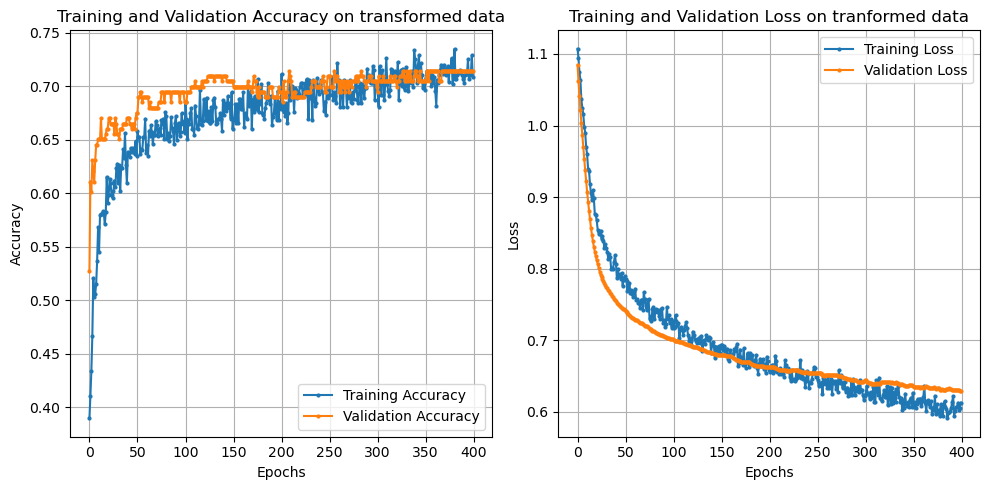

In [80]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_tr.history['accuracy'], label='Training Accuracy', marker='o', linestyle='-', markersize=2)
plt.plot(history_tr.history['val_accuracy'], label='Validation Accuracy', marker='o', linestyle='-', markersize=2)
plt.title('Training and Validation Accuracy on transformed data')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history_tr.history['loss'], label='Training Loss', marker='o', linestyle='-', markersize=2)
plt.plot(history_tr.history['val_loss'], label='Validation Loss', marker='o', linestyle='-', markersize=2)
plt.title('Training and Validation Loss on tranformed data')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [81]:
# Save the trained model
fnn_model_tr.save('fnn_model_tr.keras')

In [82]:
# Load the saved model
fnn_model_tr = load_model('fnn_model_tr.keras')

In [83]:
#Get training predictions probabilities
fnn_train_pred_tr = fnn_model_tr.predict(X_train_tr_sca)

#convert training predictions to classes
fnn_train_prob_tr = np.argmax(fnn_train_pred_tr, axis=1)

# Get test predictions probabilities
fnn_test_pred_tr = fnn_model_tr.predict(X_test_tr_sca) 

# convert prediction to classes
fnn_test_prob_tr = np.argmax(fnn_test_pred_tr, axis=1)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [84]:
#Evaluate the model performance
fnn_classification_rep_tr = classification_report(y_test_tr, fnn_test_prob_tr)
fnn_auc_tr = roc_auc_score(pd.get_dummies(y_test_tr), fnn_test_pred_tr, multi_class='ovo', average='macro')

print("Classification Report:")
print(fnn_classification_rep_tr)
print("AUC Score:")
print(fnn_auc_tr)

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75        81
           1       0.64      0.52      0.57        67
           2       0.81      0.80      0.81        55

    accuracy                           0.71       203
   macro avg       0.72      0.71      0.71       203
weighted avg       0.71      0.71      0.71       203

AUC Score:
0.8783053469237624


### 8.2.3. Ensemble predictions of the RF and FNN model trained on the feature-engineered data and Evaluate

In [85]:
# Make a dataframe of FNN predictions
fnn_predictions_tr = pd.DataFrame(fnn_test_pred_tr, columns=['Score_0', 'Score_1', 'Score_2'])
fnn_predictions_tr['Label'] = fnn_predictions_tr.idxmax(axis=1).str.replace('Score_', '').astype(int)

In [86]:
# Make a dataframe of RF predictions
rf_pred_df_tr = pd.DataFrame(rf_test_pred_de, columns=['Label'])

# Make a dataframe of probabilities
rf_prob_df_tr = pd.DataFrame(rf_test_prob_de, columns=['Score_0', 'Score_1', 'Score_2'])

# Concatenate the predictions and probabilities DataFrames
rf_predictions_tr = pd.concat([rf_pred_df_tr, rf_prob_df_tr], axis=1)

In [87]:
#Ensure both predictions DataFrames have the same index
rf_predictions_tr = rf_predictions_tr.reset_index(drop=True)
fnn_predictions_tr = fnn_predictions_tr.reset_index(drop=True)

In [88]:
# Extract necessary columns for probabilities
rf_probs_tr = rf_predictions_tr[['Score_0', 'Score_1', 'Score_2']]
fnn_probs_tr = fnn_predictions_tr[['Score_0', 'Score_1', 'Score_2']]

In [89]:
# Average the probabilities from both models
ensemble_probs_tr = (rf_probs_tr.values + fnn_probs_tr.values) / 2

# Check that the combined probabilities sum to 1
assert np.allclose(ensemble_probs_tr.sum(axis=1), 1), "Probabilities should sum to 1 for each sample"

# Determine the final predicted class based on the maximum combined probability
ensemble_pred_tr = np.argmax(ensemble_probs_tr, axis=1)

In [90]:
# Evaluate the model on our unseen data(y_test)
ensemble_classification_rep_tr = classification_report(y_test_tr, ensemble_pred_tr)
ensemble_auc_tr = roc_auc_score(pd.get_dummies(y_test_tr), ensemble_probs_tr, multi_class='ovo', average='macro')


print("Classification Report:")
print(ensemble_classification_rep_tr)
print("AUC Score:")
print(ensemble_auc_tr)

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.91      0.88        81
           1       0.84      0.84      0.84        67
           2       0.90      0.80      0.85        55

    accuracy                           0.86       203
   macro avg       0.86      0.85      0.85       203
weighted avg       0.86      0.86      0.86       203

AUC Score:
0.9572038303562698


### 8.2.4. Ensemble predictions of train and test data on the feature-engineered data and use it as features and train a meta model

In [91]:
# Combine the predictions from base models for training data
X_train_meta_tr = np.column_stack([rf_train_prob_de, fnn_train_pred_tr])
y_train_meta_tr = y_train_tr  # Target labels for the meta-model

# Combine predictions from base models for test data
X_test_meta_tr = np.column_stack([rf_test_prob_de, fnn_test_pred_tr])

In [92]:
# selection of our meta model

model_meta_tr = [[LogisticRegression(random_state=42), 'Logistic Regression'],
               [XGBClassifier(random_state=42), 'XGB Classifier'],
               [ExtraTreesClassifier(random_state=42), 'ET Classifier'],
               [SVC(probability=True,random_state=42), 'SVC']]

In [93]:
metrics_meta_tr = {'Model_meta_tr': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'ROC AUC Score': []
}

In [94]:
warnings.filterwarnings('ignore')

# Run the training loop
for models_meta_tr, model_name_meta_tr in model_meta_tr:
   
    #fit the model
    models_meta_tr.fit(X_train_meta_tr, y_train_meta_tr)
   
    #evaluate the model
    pred_meta_tr = models_meta_tr.predict(X_test_meta_tr)
    
    acc_score_meta_tr = accuracy_score(y_test_tr, pred_meta_tr)
    pre_score_meta_tr = precision_score(y_test_tr, pred_meta_tr, average='macro')
    recal_score_meta_tr = recall_score(y_test_tr, pred_meta_tr, average='macro')
    roc_score_meta_tr = roc_auc_score(y_test_tr, models_meta_tr.predict_proba(X_test_meta_tr), multi_class='ovr')
    
    # Store metrics
    metrics_meta_tr['Model_meta_tr'].append(model_name_meta_tr)
    metrics_meta_tr['Accuracy'].append(f"{round(acc_score_meta_tr * 100, 2)}%")
    metrics_meta_tr['Precision'].append(f"{round(pre_score_meta_tr * 100, 2)}%")
    metrics_meta_tr['Recall'].append(f"{round(recal_score_meta_tr * 100, 2)}%")
    metrics_meta_tr['ROC AUC Score'].append(f"{round(roc_score_meta_tr * 100, 2)}%")
    
    if model_name_meta_tr != model_meta_tr[-1][1]:
        print(f"Evaluated {model_name_meta_tr}")

Evaluated Logistic Regression
Evaluated XGB Classifier
Evaluated ET Classifier


In [95]:
# Create DataFrame from metrics dictionary
metrics_meta_tr_df = pd.DataFrame(metrics_meta_tr)

metrics_meta_tr_df

,Model_meta_tr,Accuracy,Precision,Recall,ROC AUC Score
0,Logistic Regression,89.16%,89.29%,89.29%,96.66%
1,XGB Classifier,89.66%,89.55%,89.87%,96.2%
2,ET Classifier,89.16%,89.29%,89.29%,96.16%
3,SVC,89.16%,88.99%,89.46%,93.82%


In [96]:
# initiate the XGB model
xgb_model = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', random_state=42)

In [97]:
# Define the hyperparameter search space
param_xgb = {
    'n_estimators': Integer(50, 1000),
    'max_depth': Integer(3, 20),
    'learning_rate': Real(0.01, 0.3, prior='log-uniform'),
    'colsample_bytree': Real(0.3, 1.0),
    'subsample': Real(0.4, 1.0),
    'min_child_weight': Integer(1, 10),
    'gamma': Real(1e-8, 1.0, prior='log-uniform'),
    'reg_alpha': Real(1e-8, 1.0, prior='log-uniform'),
    'reg_lambda': Real(1e-8, 1.0, prior='log-uniform')
}

In [98]:
# Set up the BayesSearchCV
bayes_xgb = BayesSearchCV(
    estimator=xgb_model,
    search_spaces=param_xgb,
    n_iter=50,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

In [99]:
# Run the optimization
xgb_fit_tr = bayes_xgb.fit(X_train_meta_tr, y_train_meta_tr)

In [100]:
# Get the best parameters and best score
best_params_xgb_tr = xgb_fit_tr.best_params_
best_score_xgb_tr = xgb_fit_tr.best_score_


# Print the best parameters and the best score
print(f"Best parameters found: {best_params_xgb_tr}")
print(f"Best accuracy found: {best_score_xgb_tr: .4f}")

Best parameters found: OrderedDict([('colsample_bytree', 1.0), ('gamma', 1.0), ('learning_rate', 0.01), ('max_depth', 10), ('min_child_weight', 10), ('n_estimators', 50), ('reg_alpha', 1.0), ('reg_lambda', 1.0), ('subsample', 0.4)])
Best accuracy found:  0.9150


In [101]:
# Train the final model with the best parameters
final_model_meta_tr = XGBClassifier(**best_params_xgb_tr, objective='multi:softprob', eval_metric='mlogloss', 
                                use_label_encoder=False, random_state=42)

final_model_meta_tr.fit(X_train_meta_tr, y_train_meta_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=1.0, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [102]:
# Predict on the test set
y_pred_meta_tr = final_model_meta_tr.predict(X_test_meta_tr)

# Get prediction probabilities
y_prob_meta_tr = final_model_meta_tr.predict_proba(X_test_meta_tr)

In [103]:
#Evaluate the model performance
meta_classification_rep_tr = classification_report(y_test_tr, y_pred_meta_tr)
meta_auc_tr = roc_auc_score(pd.get_dummies(y_test_tr), y_prob_meta_tr, multi_class='ovo', average='macro')

print("Classification Report:XGB RESULT ON PREDICTIONS OF FNN AND RF USING TRANSFORMED DATA")
print(meta_classification_rep_tr)
print("AUC score:")
print(meta_auc_tr)

Classification Report:XGB RESULT ON PREDICTIONS OF FNN AND RF USING TRANSFORMED DATA
              precision    recall  f1-score   support

           0       0.92      0.89      0.91        81
           1       0.89      0.93      0.91        67
           2       0.91      0.91      0.91        55

    accuracy                           0.91       203
   macro avg       0.91      0.91      0.91       203
weighted avg       0.91      0.91      0.91       203

AUC score:
0.9601153297550571


## 9.0. Result Evaluation


In [104]:
# Calculate metrics
metrics_all = {
    'Model': ['RF_OR', 'FNN_OR', 'RF+FNN_OR', 'LR_RF+FNN_OR', 'RF_TR', 'FNN_TR', 'RF+FNN_TR', 'XGB_RF+FNN_TR'],
    'Accuracy': [accuracy_score(y_test, rf_test_pred), accuracy_score(y_test, fnn_test_prob_or), 
                 accuracy_score(y_test, ensemble_pred), accuracy_score(y_test, y_pred_meta_or), 
                 accuracy_score(y_test_tr, rf_test_pred_de), accuracy_score(y_test_tr, fnn_test_prob_tr), 
                 accuracy_score(y_test_tr, ensemble_pred_tr), accuracy_score(y_test_tr, y_pred_meta_tr)],
    
    'Precision': [precision_score(y_test, rf_test_pred, average='macro'), 
                  precision_score(y_test, fnn_test_prob_or, average='macro'), 
                  precision_score(y_test, ensemble_pred, average='macro'),
                  precision_score(y_test, y_pred_meta_or, average='macro'),
                  precision_score(y_test_tr, rf_test_pred_de, average='macro'), 
                  precision_score(y_test_tr, fnn_test_prob_tr, average='macro'), 
                  precision_score(y_test_tr, ensemble_pred_tr, average='macro'),
                  precision_score(y_test_tr, y_pred_meta_tr, average='macro')],
    
    'Recall': [recall_score(y_test, rf_test_pred, average='macro'), 
               recall_score(y_test, fnn_test_prob_or, average='macro'), 
               recall_score(y_test, ensemble_pred, average='macro'),
               recall_score(y_test, y_pred_meta_or, average='macro'),
               recall_score(y_test_tr, rf_test_pred_de, average='macro'), 
               recall_score(y_test_tr, fnn_test_prob_tr, average='macro'), 
               recall_score(y_test_tr, ensemble_pred_tr, average='macro'),
               recall_score(y_test_tr, y_pred_meta_tr, average='macro')],
    
    'F1 Score': [f1_score(y_test, rf_test_pred, average='macro'), 
                 f1_score(y_test, fnn_test_prob_or, average='macro'),
                 f1_score(y_test, ensemble_pred, average='macro'), 
                 f1_score(y_test, y_pred_meta_or, average='macro'), 
                 f1_score(y_test_tr, rf_test_pred_de, average='macro'), 
                 f1_score(y_test_tr, fnn_test_prob_tr, average='macro'),
                 f1_score(y_test_tr, ensemble_pred_tr, average='macro'), 
                 f1_score(y_test_tr, y_pred_meta_tr, average='macro')],
    
    'AUC Score': [roc_auc_score(pd.get_dummies(y_test), rf_test_prob, multi_class='ovo', average='macro'),
                  roc_auc_score(pd.get_dummies(y_test), fnn_test_pred_or, multi_class='ovo', average='macro'),
                  roc_auc_score(pd.get_dummies(y_test), ensemble_probs, multi_class='ovo', average='macro'),
                  roc_auc_score(pd.get_dummies(y_test), y_prob_meta_or, multi_class='ovo', average='macro'),
                  roc_auc_score(pd.get_dummies(y_test_tr), rf_test_prob_de, multi_class='ovo', average='macro'),
                  roc_auc_score(pd.get_dummies(y_test_tr), fnn_test_pred_tr, multi_class='ovo', average='macro'),
                  roc_auc_score(pd.get_dummies(y_test_tr), ensemble_probs_tr, multi_class='ovo', average='macro'),
                  roc_auc_score(pd.get_dummies(y_test_tr), y_prob_meta_tr, multi_class='ovo', average='macro')]
}


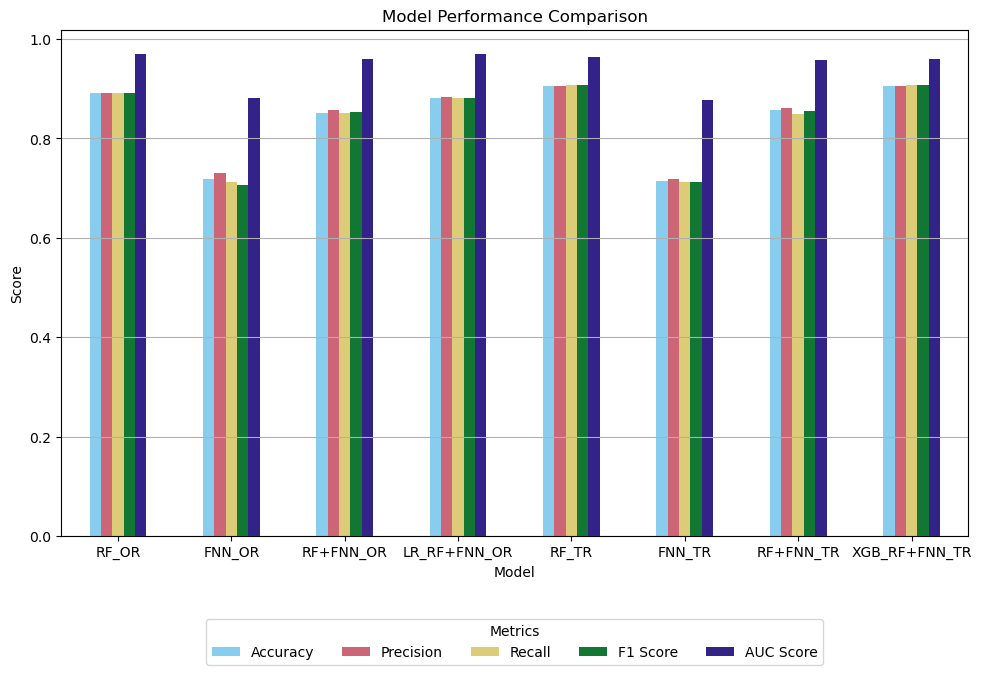

In [105]:
# Create DataFrame
df_metrics_all = pd.DataFrame(metrics_all)

# Set index for easier plotting
df_metrics_all.set_index('Model', inplace=True)

#set the colors
colors = ['#88CCEE', '#CC6677', '#DDCC77', '#117733', '#332288']

# set the fig size
#plt.subplots(figsize=(10, 6))

# Plotting
ax = df_metrics_all.plot(kind='bar', figsize=(10,6),color=colors)

#set labels and titles
plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Model Performance Comparison')

# rotate x-axis
plt.xticks(rotation=0)

#Add gridlines to y-axis
plt.grid(axis='y')

# Adjust layout for better spacing
plt.tight_layout()

#Move the legend below the x-axis
plt.legend(title='Metrics', loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=len(df_metrics_all.columns))

#show plot
plt.show();

In [106]:
df_metrics_all

,Accuracy,Precision,Recall,F1 Score,AUC Score
Model,,,,,
RF_OR,0.891626,0.892351,0.891548,0.891112,0.969685
FNN_OR,0.719212,0.730045,0.713302,0.705967,0.881732
RF+FNN_OR,0.852217,0.856660,0.850661,0.853335,0.960629
LR_RF+FNN_OR,0.881773,0.883785,0.880738,0.882133,0.970434
RF_TR,0.906404,0.905961,0.907784,0.906620,0.963927
FNN_TR,0.714286,0.717769,0.712401,0.711799,0.878305
RF+FNN_TR,0.857143,0.861452,0.849800,0.854309,0.957204
XGB_RF+FNN_TR,0.906404,0.905961,0.907784,0.906620,0.960115


***Observation on the results*** 
- Models trained on the transformed data outperformed those trained on the original data
- Random Forest with default parameters trained on the transformed data has the same result with xgb classifier with optimized parameter trained on the ensemble predictions of the Random Forest and FNN.

## 9.1 Further evaluation 

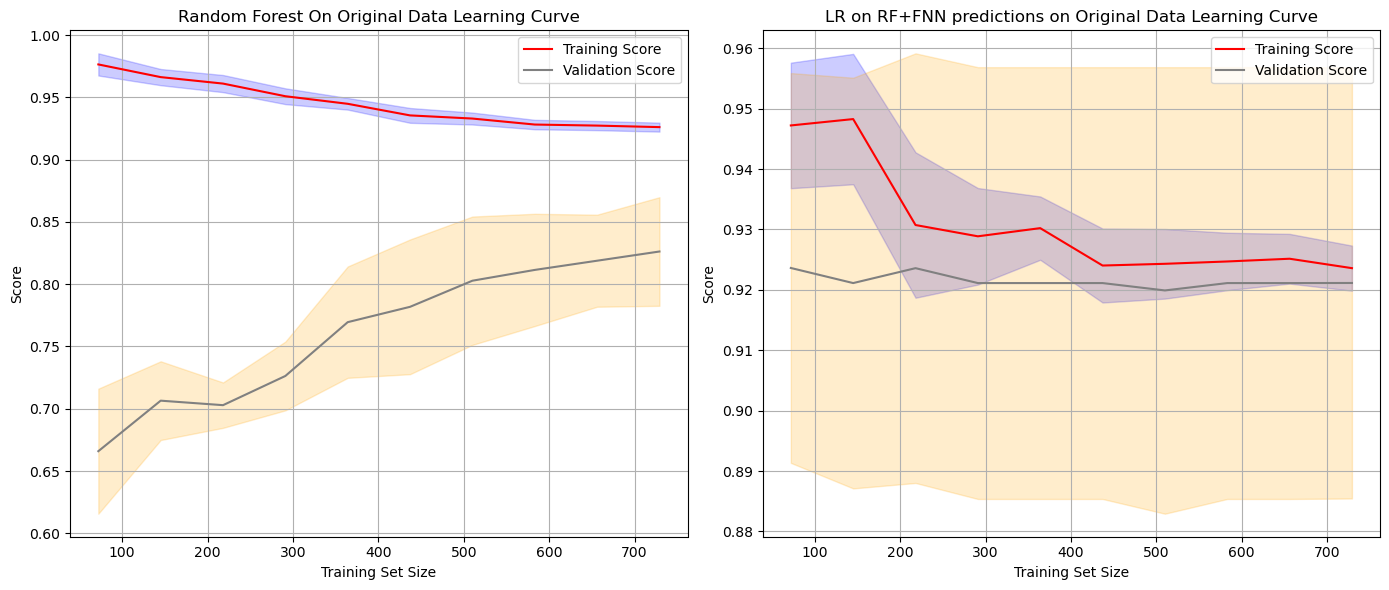

In [107]:
# plot learning curve to understand how the models performed across different folds in our transformed data

# Generate learning curves for Random Forest
train_sizes_rf_or, train_scores_rf_or, val_scores_rf_or = learning_curve(model_rf_or, X_train_or, y_train, 
                                                                cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), 
                                                                n_jobs=-1, 
                                                                train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

# Generate learning curves for Feedforward Neural Network
train_sizes_lr, train_scores_lr, val_scores_lr = learning_curve(final_model_meta, X_train_meta_or,
                                                                   y_train_meta_or,
                                                                   cv=StratifiedKFold(n_splits=10, 
                                                                                      shuffle=True, random_state=42), 
                                                                   n_jobs=-1, 
                                                                   train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

# Calculate mean and standard deviation for training and validation scores
train_mean_rf_or = np.mean(train_scores_rf_or, axis=1)
train_std_rf_or = np.std(train_scores_rf_or, axis=1)
val_mean_rf_or = np.mean(val_scores_rf_or, axis=1)
val_std_rf_or = np.std(val_scores_rf_or, axis=1)

train_mean_lr = np.mean(train_scores_lr, axis=1)
train_std_lr = np.std(train_scores_lr, axis=1)
val_mean_lr = np.mean(val_scores_lr, axis=1)
val_std_lr = np.std(val_scores_lr, axis=1)

# Plotting the learning curves in subplots
plt.figure(figsize=(14, 6))

# Random Forest Learning Curve
plt.subplot(1, 2, 1)
plt.plot(train_sizes_rf_or, train_mean_rf_or, label='Training Score', color='red')
plt.plot(train_sizes_rf_or, val_mean_rf_or, label='Validation Score', color='gray')
plt.fill_between(train_sizes_rf_or, train_mean_rf_or - train_std_rf_or, train_mean_rf_or + train_std_rf_or, color='blue', 
                 alpha=0.2)
plt.fill_between(train_sizes_rf_or, val_mean_rf_or - val_std_rf_or, val_mean_rf_or + val_std_rf_or, color='orange', alpha=0.2)
plt.title('Random Forest On Original Data Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()

# LR on RF+FNN Predictions Learning Curve
plt.subplot(1, 2, 2)
plt.plot(train_sizes_lr, train_mean_lr, label='Training Score', color='red')
plt.plot(train_sizes_lr, val_mean_lr, label='Validation Score', color='gray')
plt.fill_between(train_sizes_lr, train_mean_lr - train_std_lr, train_mean_lr + train_std_lr, color='blue', alpha=0.2)
plt.fill_between(train_sizes_lr, val_mean_lr - val_std_lr, val_mean_lr + val_std_lr, color='orange', alpha=0.2)
plt.title('LR on RF+FNN predictions on Original Data Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

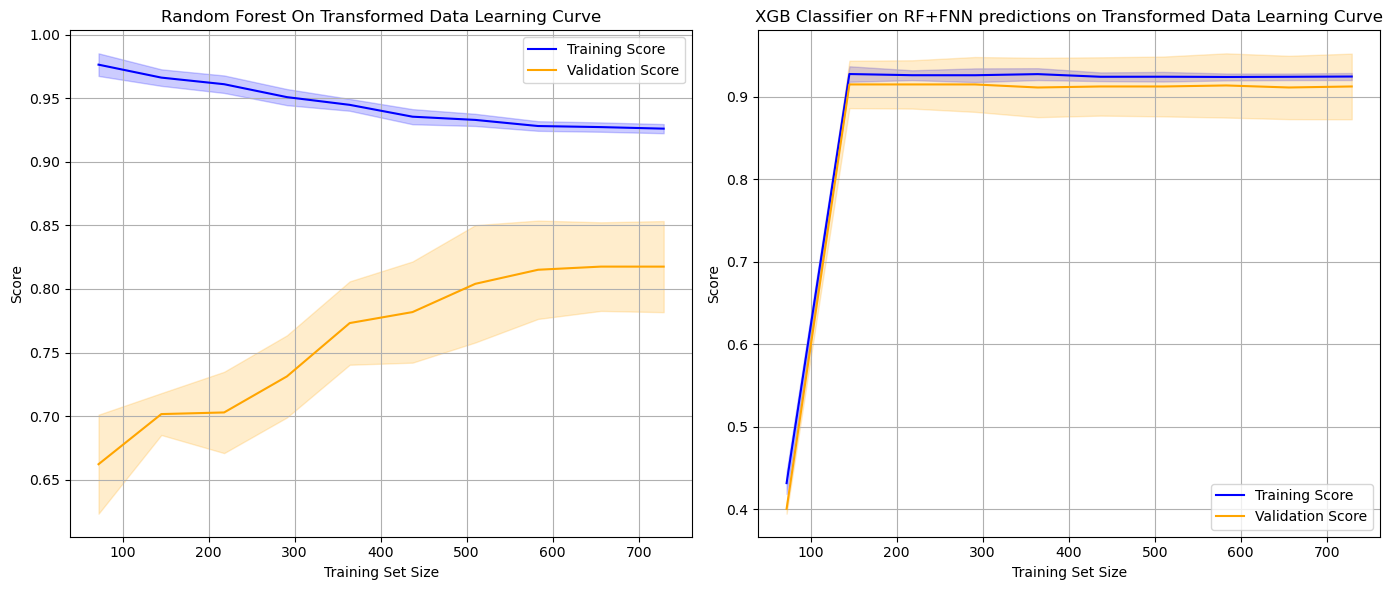

In [108]:
# plot learning curve to understand how the models performed across different folds in our transformed data

# Generate learning curves for Random Forest
train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(rf_default, X_train_tr_sca, y_train_tr, 
                                                                cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42), 
                                                                n_jobs=-1, 
                                                                train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

# Generate learning curves for Feedforward Neural Network
train_sizes_xgb, train_scores_xgb, val_scores_xgb = learning_curve(final_model_meta_tr, X_train_meta_tr,
                                                                   y_train_meta_tr,
                                                                   cv=StratifiedKFold(n_splits=10, 
                                                                                      shuffle=True, random_state=42), 
                                                                   n_jobs=-1, 
                                                                   train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

# Calculate mean and standard deviation for training and validation scores
train_mean_rf = np.mean(train_scores_rf, axis=1)
train_std_rf = np.std(train_scores_rf, axis=1)
val_mean_rf = np.mean(val_scores_rf, axis=1)
val_std_rf = np.std(val_scores_rf, axis=1)

train_mean_xgb = np.mean(train_scores_xgb, axis=1)
train_std_xgb = np.std(train_scores_xgb, axis=1)
val_mean_xgb = np.mean(val_scores_xgb, axis=1)
val_std_xgb = np.std(val_scores_xgb, axis=1)

# Plotting the learning curves in subplots
plt.figure(figsize=(14, 6))

# Random Forest Learning Curve
plt.subplot(1, 2, 1)
plt.plot(train_sizes_rf, train_mean_rf, label='Training Score', color='blue')
plt.plot(train_sizes_rf, val_mean_rf, label='Validation Score', color='orange')
plt.fill_between(train_sizes_rf, train_mean_rf - train_std_rf, train_mean_rf + train_std_rf, color='blue', alpha=0.2)
plt.fill_between(train_sizes_rf, val_mean_rf - val_std_rf, val_mean_rf + val_std_rf, color='orange', alpha=0.2)
plt.title('Random Forest On Transformed Data Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()

# XGB on RF+FNN Predictions Learning Curve
plt.subplot(1, 2, 2)
plt.plot(train_sizes_xgb, train_mean_xgb, label='Training Score', color='blue')
plt.plot(train_sizes_xgb, val_mean_xgb, label='Validation Score', color='orange')
plt.fill_between(train_sizes_xgb, train_mean_xgb - train_std_xgb, train_mean_xgb + train_std_xgb, color='blue', alpha=0.2)
plt.fill_between(train_sizes_xgb, val_mean_xgb - val_std_xgb, val_mean_xgb + val_std_xgb, color='orange', alpha=0.2)
plt.title('XGB Classifier on RF+FNN predictions on Transformed Data Learning Curve')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.legend(loc='best')
plt.grid()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

***Observation on the plotted Learning Curve***
- Random Forest:  The steady increase in the CV score as more data is added shows that our model is generalizing well to unseen data. But the difference between the cv and training score is wide suggesting that our model is overfitting of the training set.
- XGB Classifer: The plot suggest that our cv score gradually learns the pattern and as some point, flattens out. This gradually learning which marches the training score shows that our model is robust and has no sign of overfitting or underfitting.

Hence our selected model for this study is a meta model(XGB) trained on the ensembled predictions of RF and FNN using the transformed data

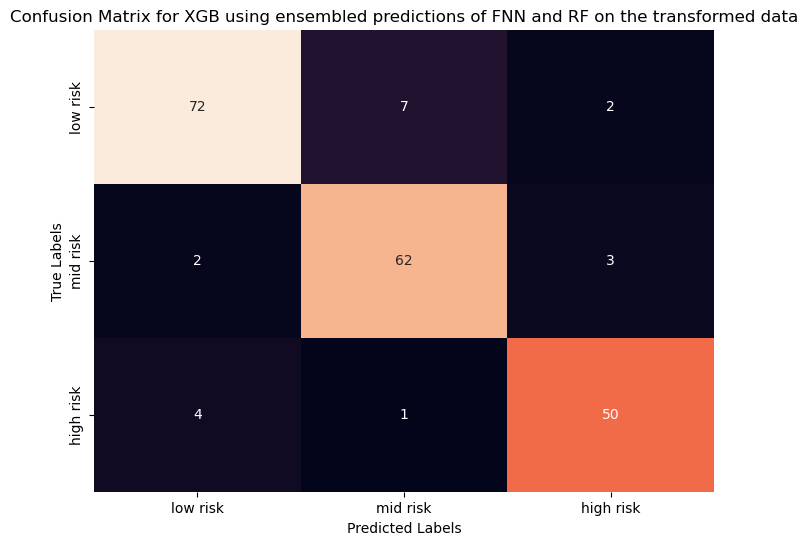

In [109]:
# Plot the confusion matrix of the final selected model

cm_xgb = confusion_matrix(y_test_tr, y_pred_meta_tr)

cc = ['#DDCC77', '#117733', '#332288']

# Plot the confusion matrix 
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', color=cc, cbar=False, xticklabels=risk_map.keys(), yticklabels=risk_map.keys())
plt.title('Confusion Matrix for XGB using ensembled predictions of FNN and RF on the transformed data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

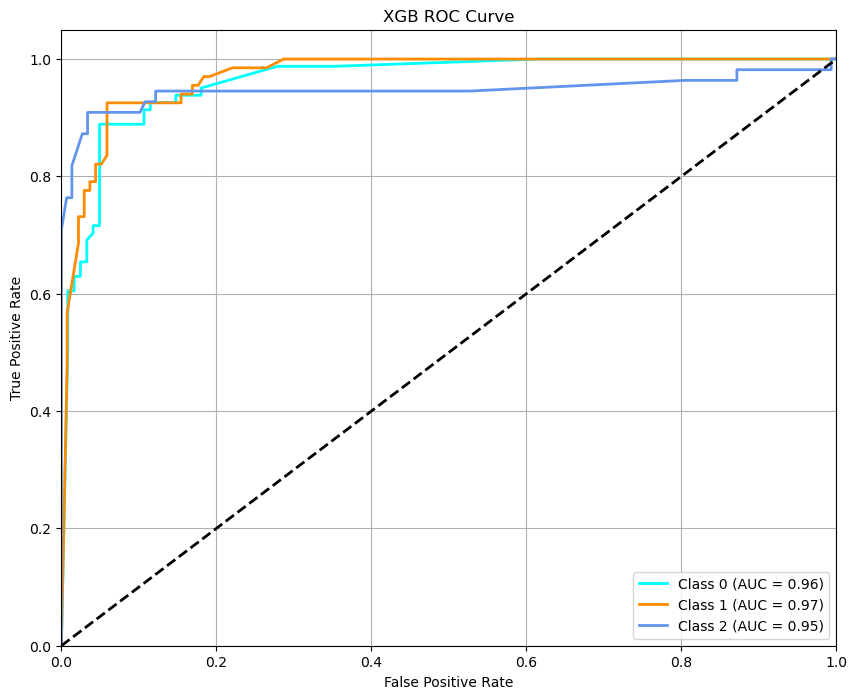

In [110]:
from itertools import cycle

# plot the ROC_AUC score
# Select probabilities for the positive class
xgb_prob = final_model_meta_tr.predict_proba(X_test_meta_tr)

# Binarize the output labels
y_test_tr_bin = label_binarize(y_test_tr, classes=np.unique(y_test_tr))
n_classes = y_test_tr_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_tr_bin[:, i], xgb_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line for random guess
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGB ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


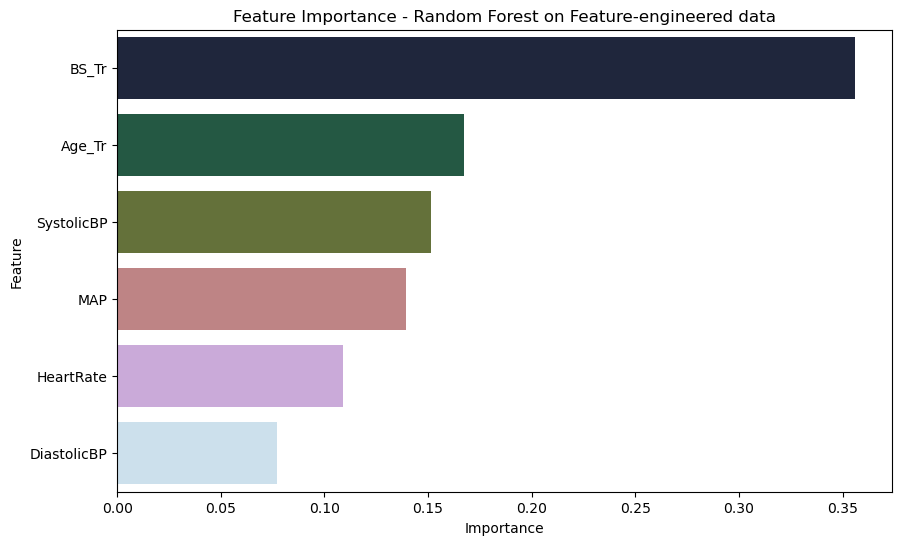

In [112]:
# plot feature importance of the RF used on the transformed data
# Get feature importances from the RF model
feature_imp = rf_default.feature_importances_

# Create a DataFrame for easier plotting
features_df = pd.DataFrame({
    'Feature': X_tr.columns,
    'Importance': feature_imp
})

# Sort the DataFrame by importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df, palette='cubehelix')
plt.title('Feature Importance - Random Forest on Feature-engineered data')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


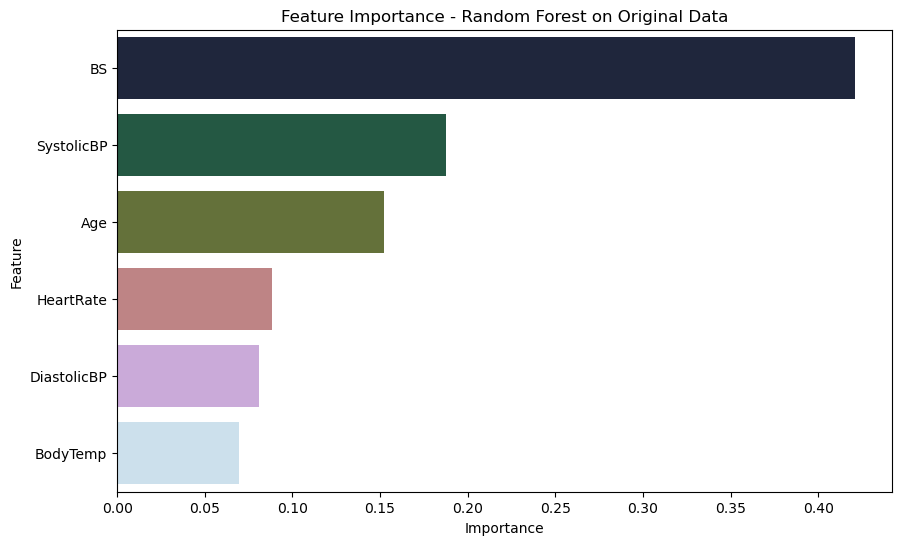

In [113]:
# plot feature importance of the RF used on the transformed data
# Get feature importances from the RF model
feature_imp_or = model_rf_or.feature_importances_

# Create a DataFrame for easier plotting
features_df_or = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_imp_or
})

# Sort the DataFrame by importance
features_df_or = features_df_or.sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=features_df_or, palette='cubehelix')
plt.title('Feature Importance - Random Forest on Original Data')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()